In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

trivikramu_optriae_path = kagglehub.dataset_download('trivikramu/optriae')
trivikramu_oprita_path = kagglehub.dataset_download('trivikramu/oprita')

print('Data source import complete.')


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# STEP 1: Install Python 3.8 and create virtual environment
!sudo apt-get update
!sudo apt-get install -y python3.8 python3.8-venv python3.8-dev

# STEP 2: Create and activate the virtual environment
!python3.8 -m venv py38env
!py38env/bin/pip install --upgrade pip setuptools wheel

# STEP 3: Install compatible packages
!py38env/bin/pip install scikit-learn==0.24.2
!py38env/bin/pip install auto-sklearn
!py38env/bin/pip install openml
!py38env/bin/pip install  matplotlib seaborn
# !py38env/bin/pip install  pandas



Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:10 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:11 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,607 kB]
Get:12 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,244 kB]
Get:13 http://security.ubuntu.com/ubun

In [3]:
# Code to save as Python script for execution
code = """


if __name__ == "__main__":
    import matplotlib
    matplotlib.use('Agg')
    import matplotlib.pyplot as plt
    import openml
    import autosklearn.classification
    from sklearn.model_selection import train_test_split
    from sklearn.multioutput import MultiOutputClassifier
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
    import pandas as pd
    import numpy as np
    import time
    from sklearn.compose import ColumnTransformer
    from sklearn.preprocessing import OneHotEncoder
    from sklearn.impute import SimpleImputer
    import seaborn as sns
    import os

    dataset_ids = [40594, 40597, 40591]  # reuters, yeast, genbase
    results = []
    results_labels = []
    metrics_data = {
        "Dataset": [],
        "Accuracy (Micro)": [],
        "Precision (Micro)": [],
        "Recall (Micro)": [],
        "F1 (Micro)": []
    }

    for openml_id in dataset_ids:
        print(f"🚀 Running Auto-Sklearn on Dataset {openml_id}")
        dataset = openml.datasets.get_dataset(openml_id)
        df, _, _, _ = dataset.get_data()

        target_cols = dataset.default_target_attribute.split(",")
        target_cols = [col.strip() for col in target_cols]

        X = df.drop(columns=target_cols)
        y = df[target_cols].astype(int)

        categorical_cols = X.select_dtypes(include=["object", "category"]).columns
        numeric_cols = X.select_dtypes(include=["number", "bool"]).columns

        preprocessor = ColumnTransformer([
            ("num", SimpleImputer(strategy="mean"), numeric_cols),
            ("cat", OneHotEncoder(handle_unknown="ignore", sparse=False), categorical_cols),
        ])

        X_processed = preprocessor.fit_transform(X)
        X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.33, random_state=42)

        base_classifier = autosklearn.classification.AutoSklearnClassifier(
            time_left_for_this_task=60,
            per_run_time_limit=30,
            n_jobs=-1,
            initial_configurations_via_metalearning=25,
        )
        model = MultiOutputClassifier(base_classifier)

        start_time = time.time()
        model.fit(X_train, y_train)
        fit_time = time.time() - start_time

        y_pred = model.predict(X_test)

        target_metrics = {}
        accuracies, precisions, recalls, f1s = [], [], [], []

        for i, col in enumerate(y.columns):
            y_true = y_test.iloc[:, i]
            y_pred_col = y_pred[:, i]

            acc = accuracy_score(y_true, y_pred_col)
            prec = precision_score(y_true, y_pred_col, average='macro', zero_division=0)
            rec = recall_score(y_true, y_pred_col, average='macro', zero_division=0)
            f1 = f1_score(y_true, y_pred_col, average='macro', zero_division=0)

            target_metrics[f"{col}_Accuracy"] = round(acc, 4)
            target_metrics[f"{col}_Precision"] = round(prec, 4)
            target_metrics[f"{col}_Recall"] = round(rec, 4)
            target_metrics[f"{col}_F1"] = round(f1, 4)

            accuracies.append(acc)
            precisions.append(prec)
            recalls.append(rec)
            f1s.append(f1)

        avg_acc = np.mean(accuracies)
        avg_prec = np.mean(precisions)
        avg_rec = np.mean(recalls)
        avg_f1 = np.mean(f1s)

        metrics_data["Dataset"].append(dataset.name)
        metrics_data["Accuracy (Micro)"].append(round(avg_acc, 4))
        metrics_data["Precision (Micro)"].append(round(avg_prec, 4))
        metrics_data["Recall (Micro)"].append(round(avg_rec, 4))
        metrics_data["F1 (Micro)"].append(round(avg_f1, 4))

        result_row = {
            "Dataset ID": openml_id,
            "Dataset Name": dataset.name,
            "AutoSklearn Avg Accuracy": round(avg_acc, 4),
            "AutoSklearn Avg Precision": round(avg_prec, 4),
            "AutoSklearn Avg Recall": round(avg_rec, 4),
            "AutoSklearn Avg F1": round(avg_f1, 4),
            "Fit Time (s)": round(fit_time, 2),
        }
        result_row.update(target_metrics)
        results.append(result_row)

        # ✅ Store per-dataset label metrics
        results_labels.append({
            "dataset": dataset.name,
            "label_metrics": target_metrics
        })

    # ✅ Save results
    os.makedirs("plots", exist_ok=True)
    results_df = pd.DataFrame(results)
    results_df.to_csv("plots/summary_results.csv", index=False)

    metrics_df = pd.DataFrame(metrics_data)
    metrics_df.reset_index(drop=True, inplace=True)

    # ✅ 1. Micro Metrics Bar Plot
    sns.set_theme(style="whitegrid")
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    sns.barplot(data=metrics_df, x="Dataset", y="Accuracy (Micro)", ax=axes[0, 0])
    axes[0, 0].set_title('Micro Accuracy')

    sns.barplot(data=metrics_df, x="Dataset", y="Precision (Micro)", ax=axes[0, 1])
    axes[0, 1].set_title('Micro Precision')

    sns.barplot(data=metrics_df, x="Dataset", y="Recall (Micro)", ax=axes[1, 0])
    axes[1, 0].set_title('Micro Recall')

    sns.barplot(data=metrics_df, x="Dataset", y="F1 (Micro)", ax=axes[1, 1])
    axes[1, 1].set_title('Micro F1 Score')

    for ax in axes.flat:
        ax.tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.savefig("plots/overall_micro_metrics.png")
    plt.close()

    # ✅ 2. Per-label Line Plot across Datasets
    for metric in ["Accuracy", "Precision", "Recall", "F1"]:
        plt.figure(figsize=(16, 6))
        label_set = set()

        # Collect all labels
        for entry in results_labels:
            label_set.update([
                k.replace(f"_{metric}", "")
                for k in entry["label_metrics"].keys()
                if k.endswith(f"_{metric}")
            ])

        label_set = sorted(list(label_set))
        for label in label_set:
            values = []
            datasets = []
            for entry in results_labels:
                datasets.append(entry["dataset"])
                values.append(entry["label_metrics"].get(f"{label}_{metric}", 0))
            plt.plot(datasets, values, label=label)

        plt.title(f"{metric} per Label across Datasets")
        plt.xlabel("Dataset")
        plt.ylabel(metric)
        plt.legend(title="Label", bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.savefig(f"plots/{metric}_per_label_line.png")
        plt.close()

    # ✅ 3. Per-Dataset Bar Plot per Label
    for entry in results_labels:
        dataset_name = entry["dataset"]
        label_metrics = entry["label_metrics"]

        for metric in ["Accuracy", "Precision", "F1"]:
            plt.figure(figsize=(14, 6))
            labels = []
            values = []

            for key, val in label_metrics.items():
                if key.endswith(f"_{metric}"):
                    label = key.replace(f"_{metric}", "")
                    labels.append(label)
                    values.append(val)

            sns.barplot(x=labels, y=values)
            plt.title(f"{metric} per Label - {dataset_name}")
            plt.xlabel("Label")
            plt.ylabel(metric)
            plt.xticks(rotation=45, ha="right")
            plt.tight_layout()

            filename = f"plots/{dataset_name}_{metric.lower()}_per_label.png".replace(" ", "_")
            plt.savefig(filename)
            plt.close()








"""
# Save the code to a Python script file
with open("autosklearn_test.py", "w") as f:
    f.write(code)

# Step 4: Run the script using the virtual environment
# !py38env/bin/python autosklearn_test.py


!py38env/bin/python autosklearn_test.py



🚀 Running Auto-Sklearn on Dataset 40594
[WARNING] [2025-05-01 08:04:00,951:Client-AutoML(1):d57ee198-2662-11f0-9077-0242ac1c000c] Capping the per_run_time_limit to 29.0 to have time for a least 2 models in each process.
[WARNING] [2025-05-01 08:04:56,898:Client-AutoML(1):f7f8df9c-2662-11f0-9077-0242ac1c000c] Capping the per_run_time_limit to 29.0 to have time for a least 2 models in each process.
[WARNING] [2025-05-01 08:05:52,367:Client-AutoML(1):195c944a-2663-11f0-9077-0242ac1c000c] Capping the per_run_time_limit to 29.0 to have time for a least 2 models in each process.
[WARNING] [2025-05-01 08:05:57,113:Client-EnsembleBuilder] No runs were available to build an ensemble from
[WARNING] [2025-05-01 08:06:47,811:Client-AutoML(1):39ec9832-2663-11f0-9077-0242ac1c000c] Capping the per_run_time_limit to 29.0 to have time for a least 2 models in each process.
[WARNING] [2025-05-01 08:07:42,629:Client-AutoML(1):5afea71a-2663-11f0-9077-0242ac1c000c] Capping the per_run_time_limit to 29.0 to 

📊 Accuracy_per_label_line.png


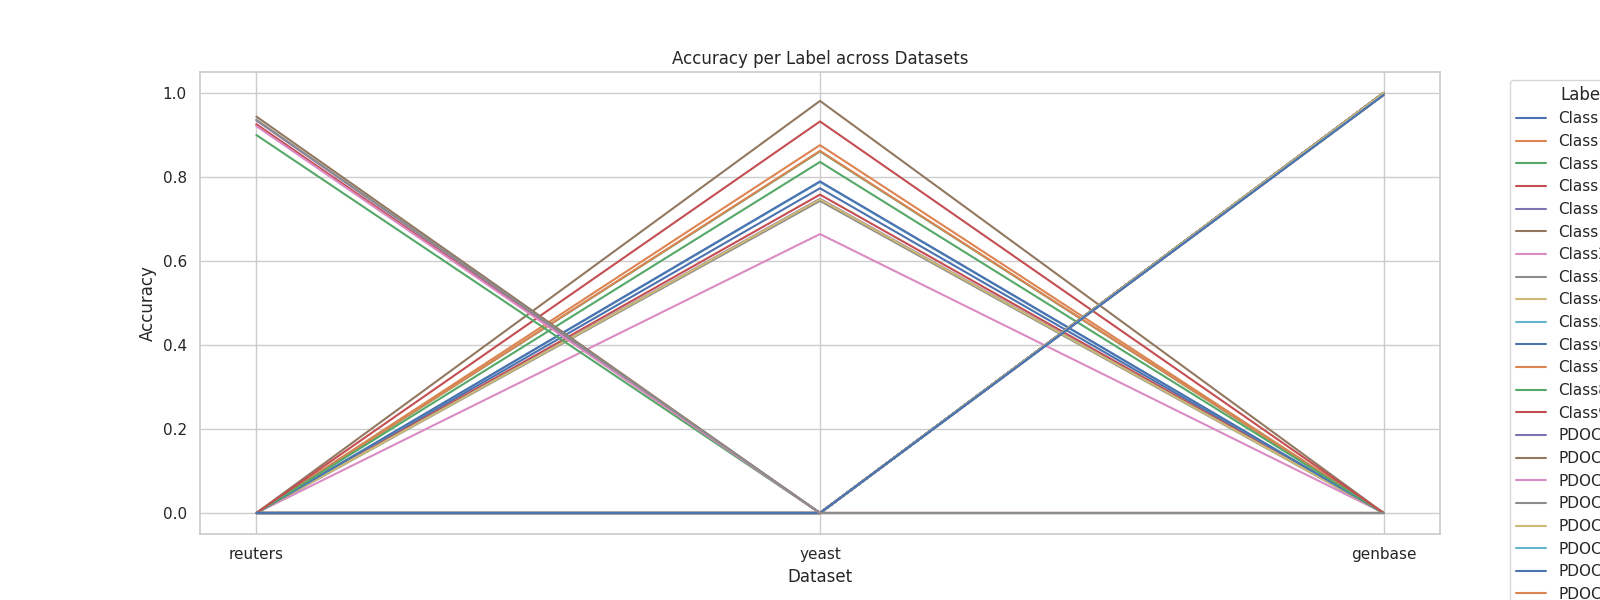

📊 F1_per_label_line.png


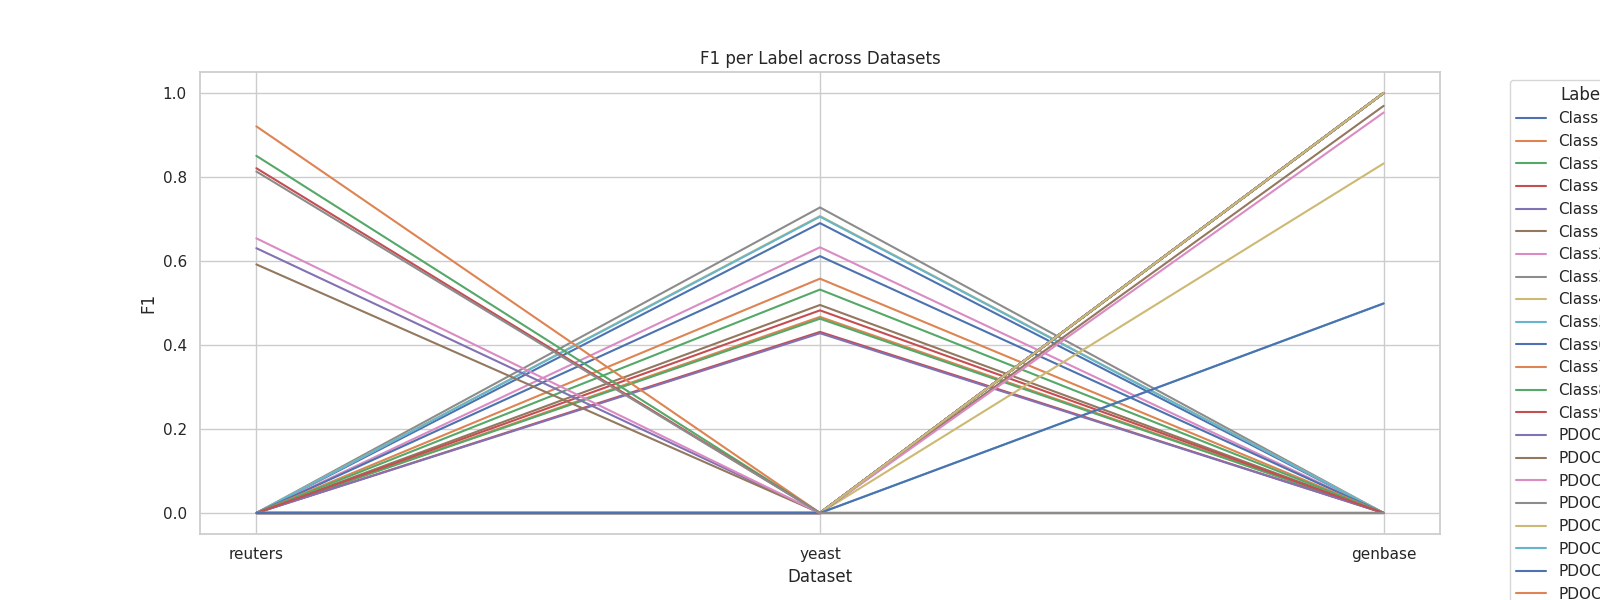

📊 Precision_per_label_line.png


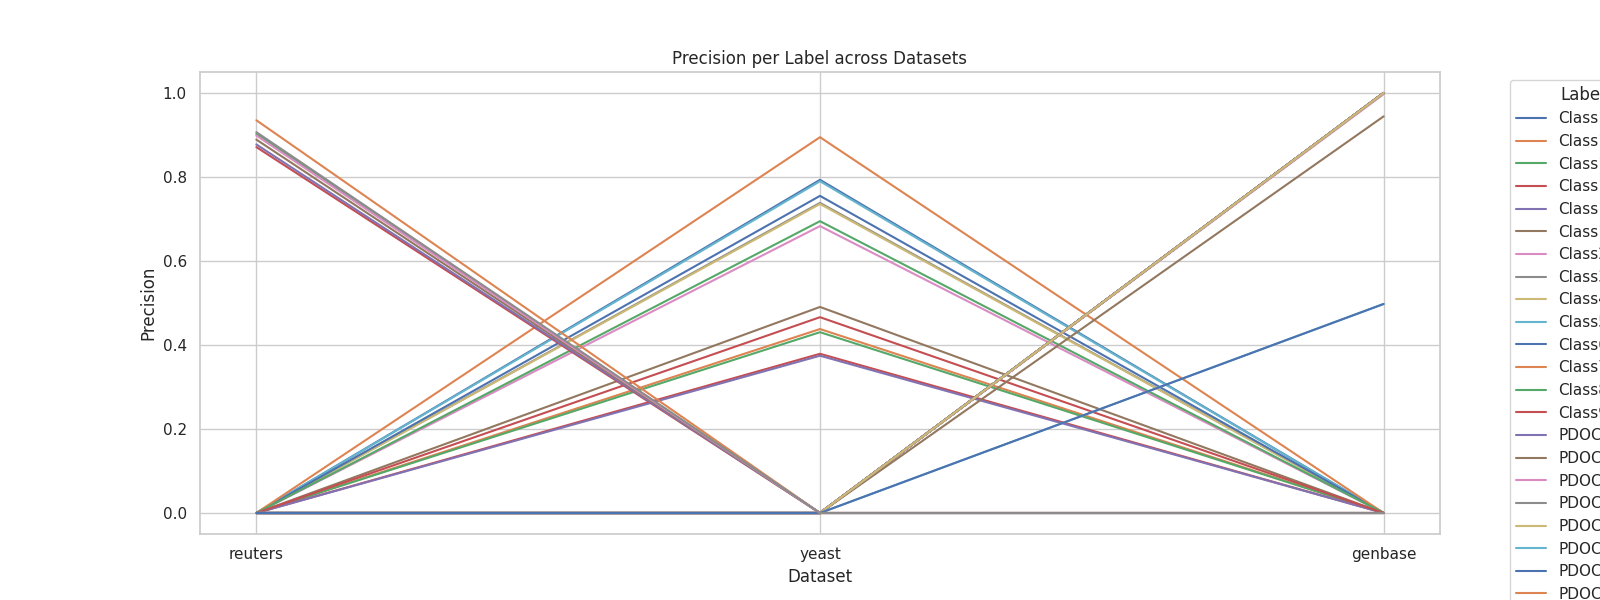

📊 Recall_per_label_line.png


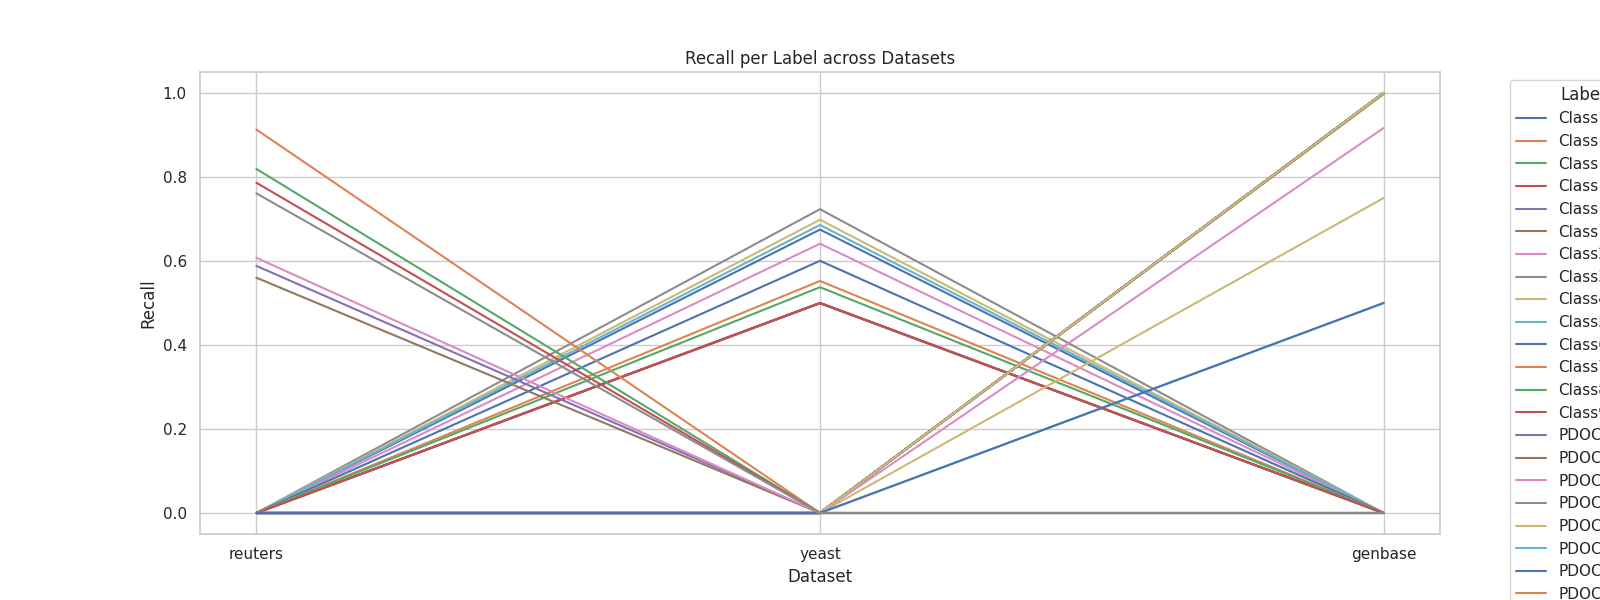

📊 genbase_accuracy_per_label.png


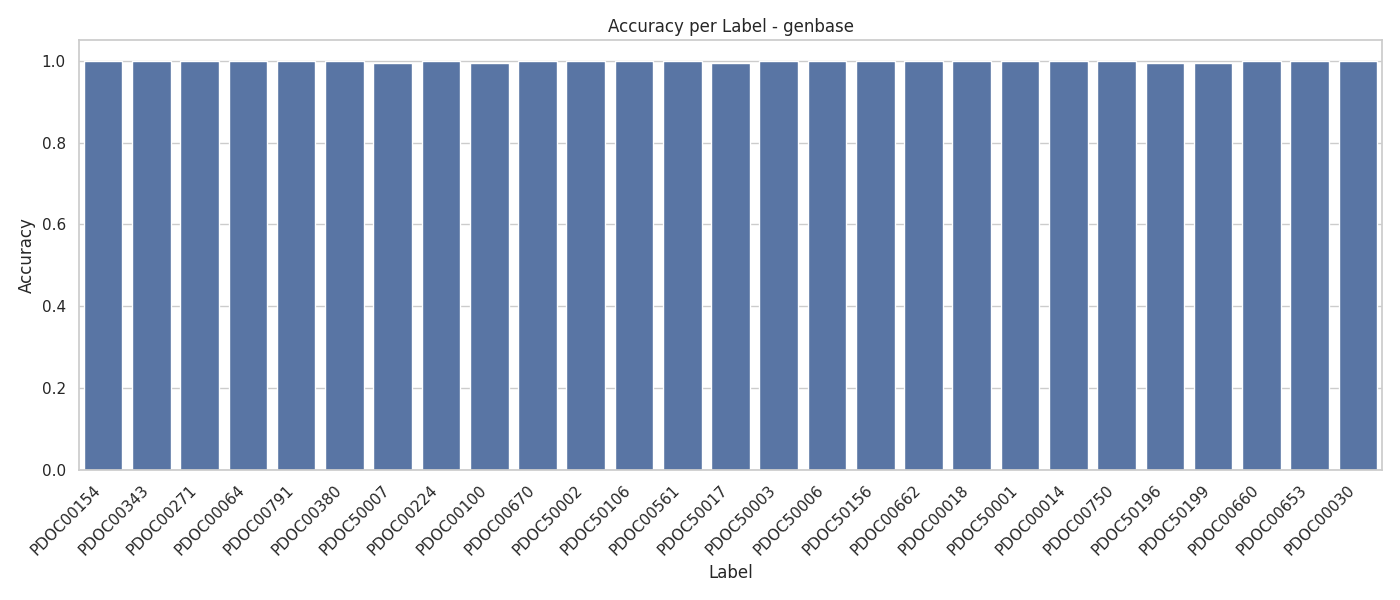

📊 genbase_f1_per_label.png


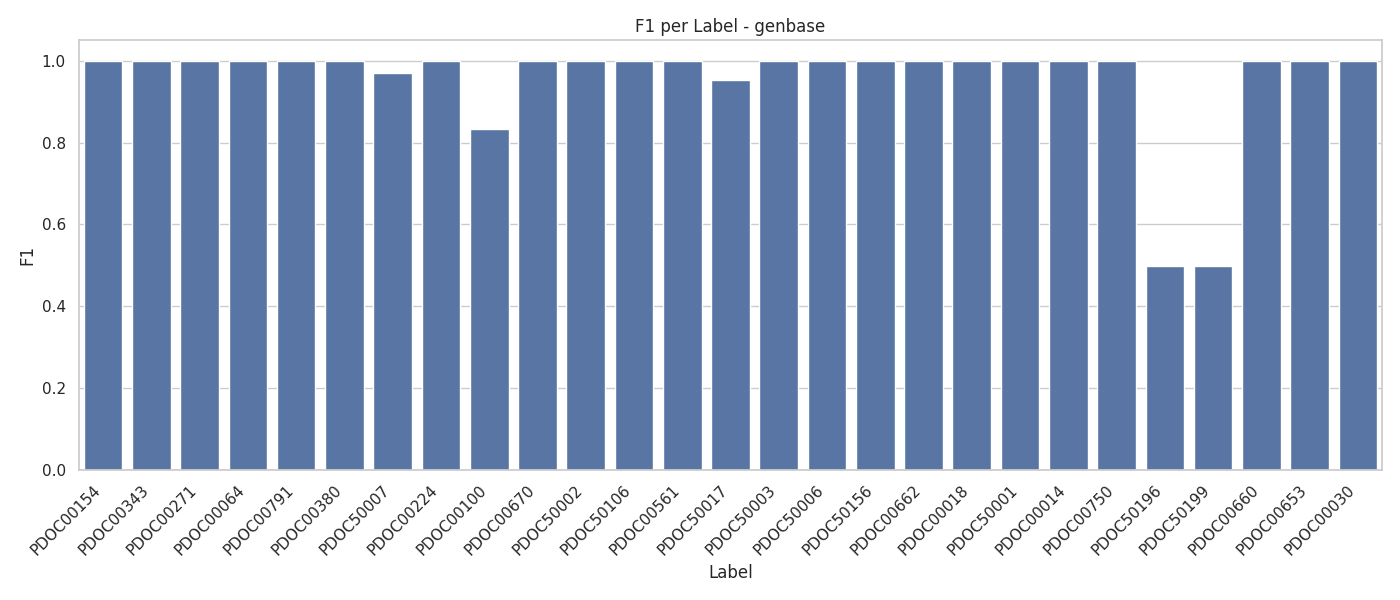

📊 genbase_precision_per_label.png


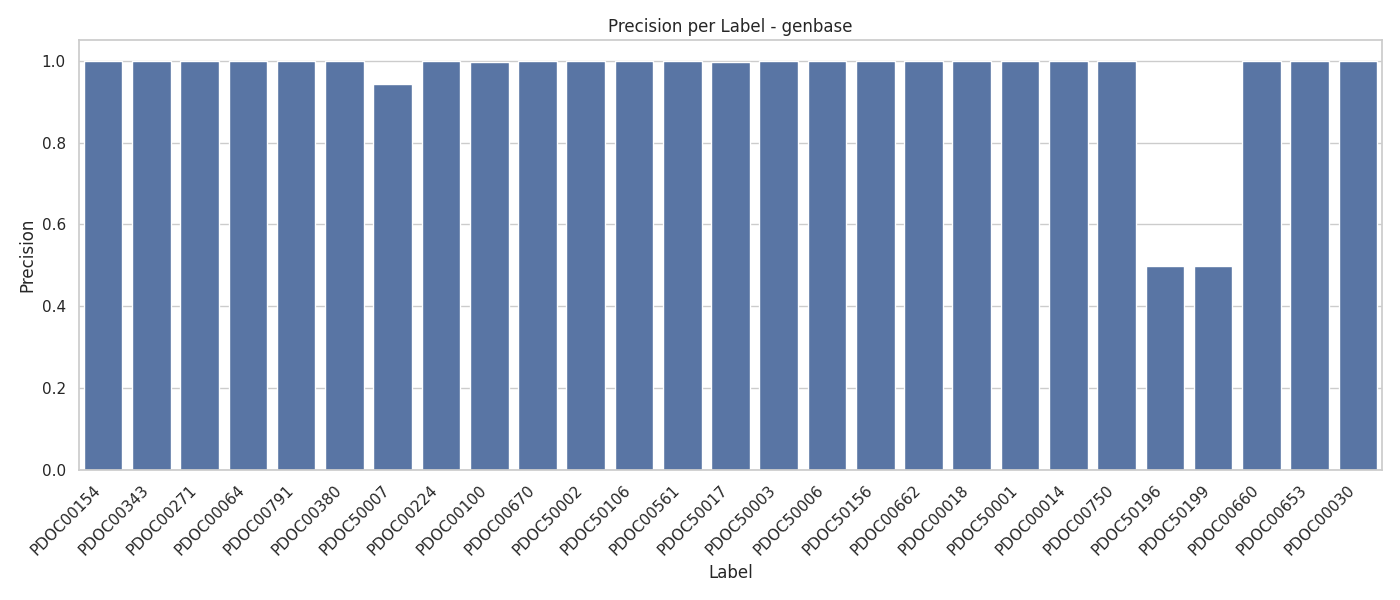

📊 overall_micro_metrics.png


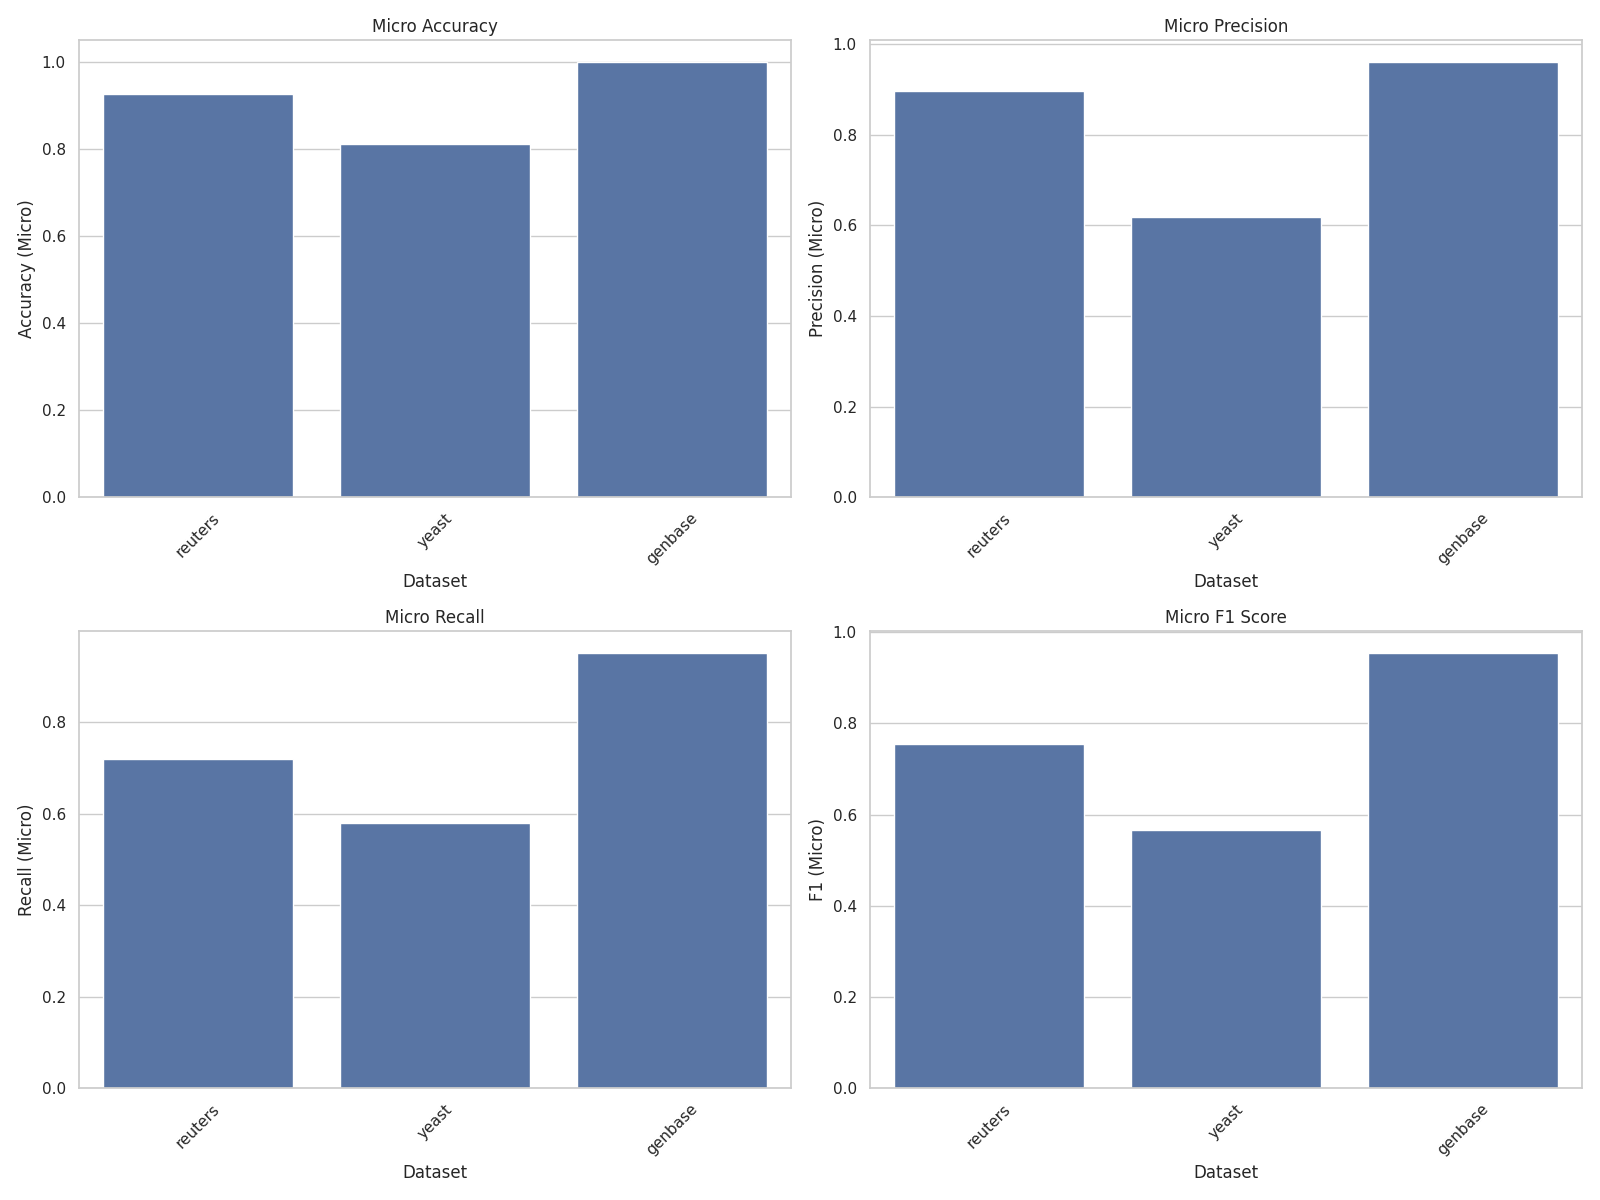

📊 reuters_accuracy_per_label.png


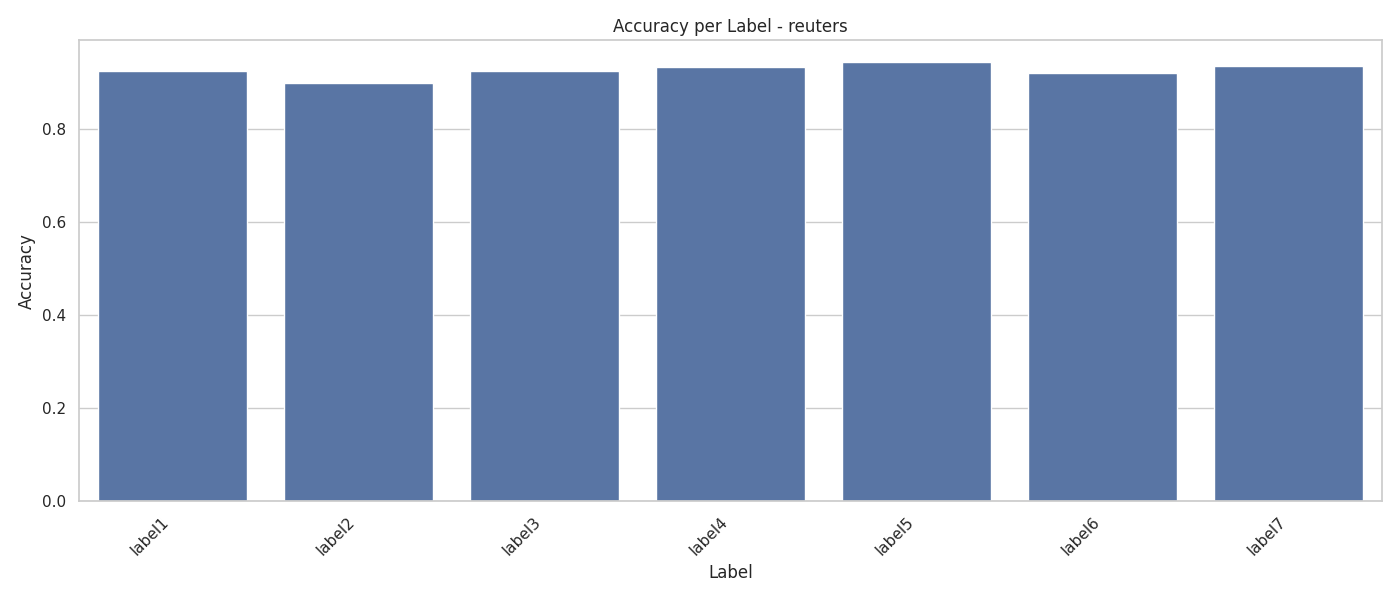

📊 reuters_f1_per_label.png


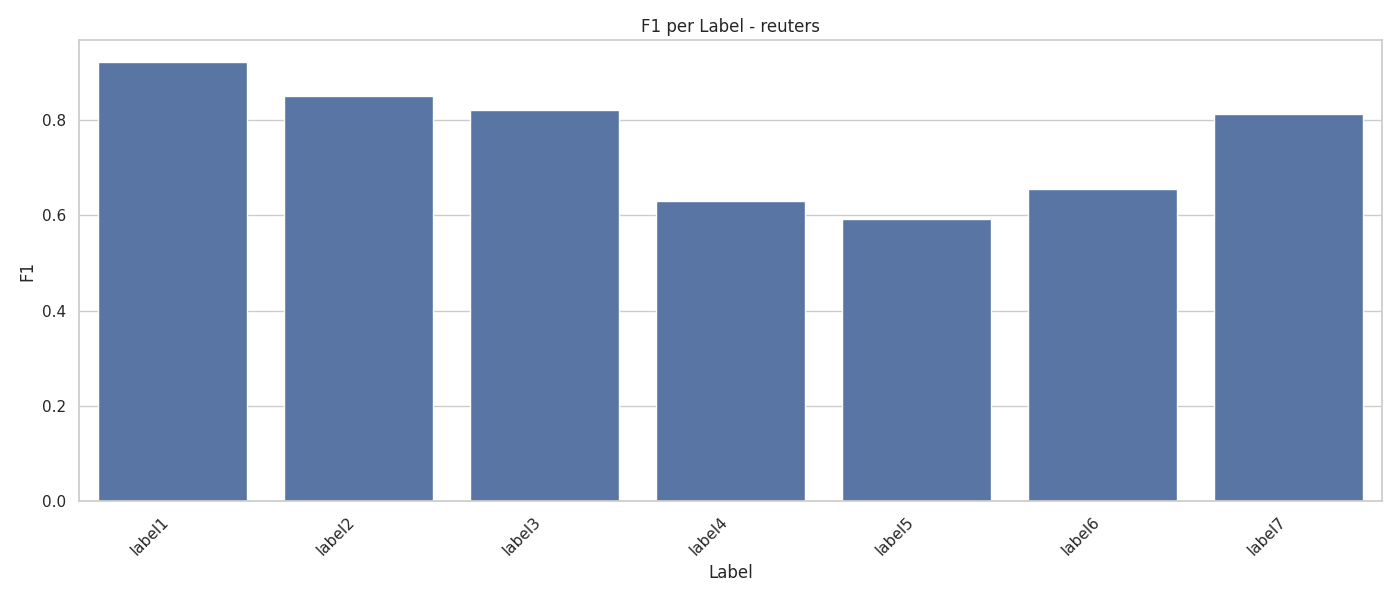

📊 reuters_precision_per_label.png


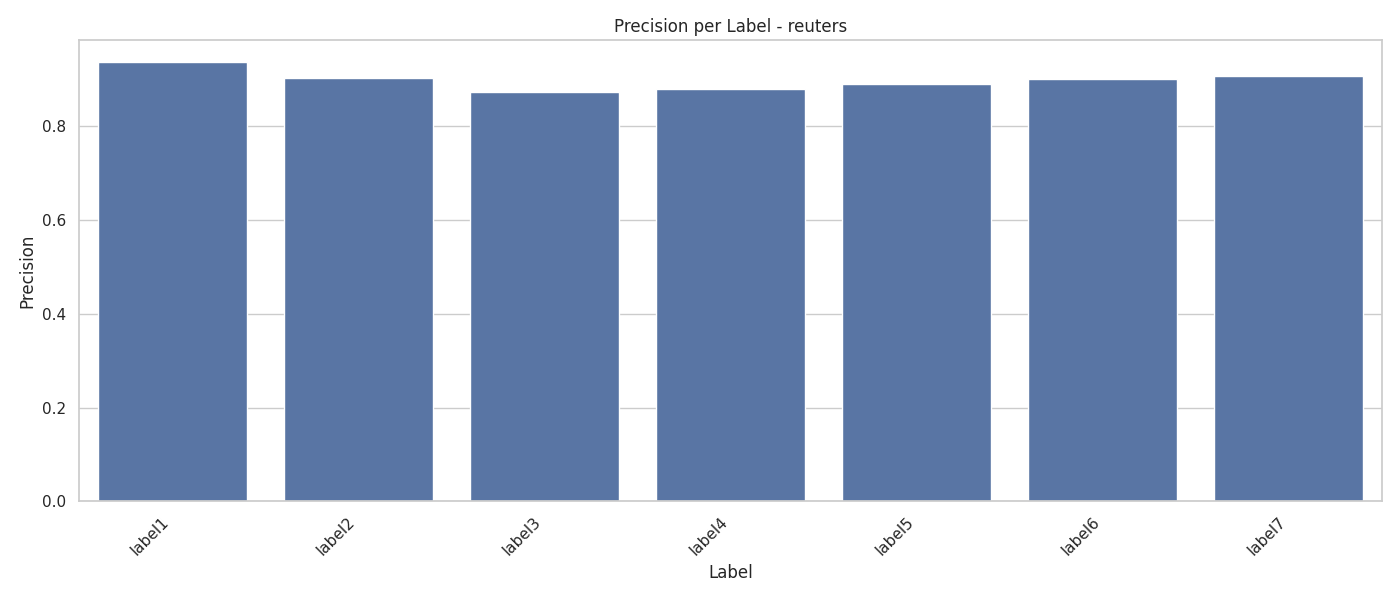

📊 yeast_accuracy_per_label.png


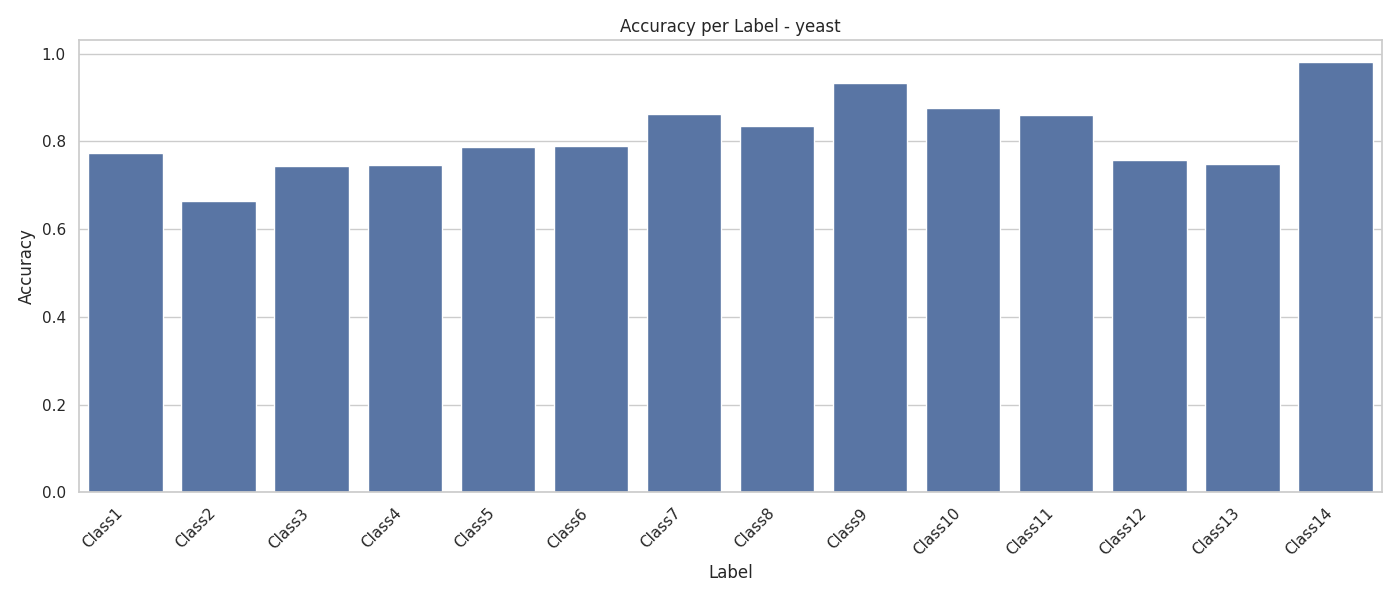

📊 yeast_f1_per_label.png


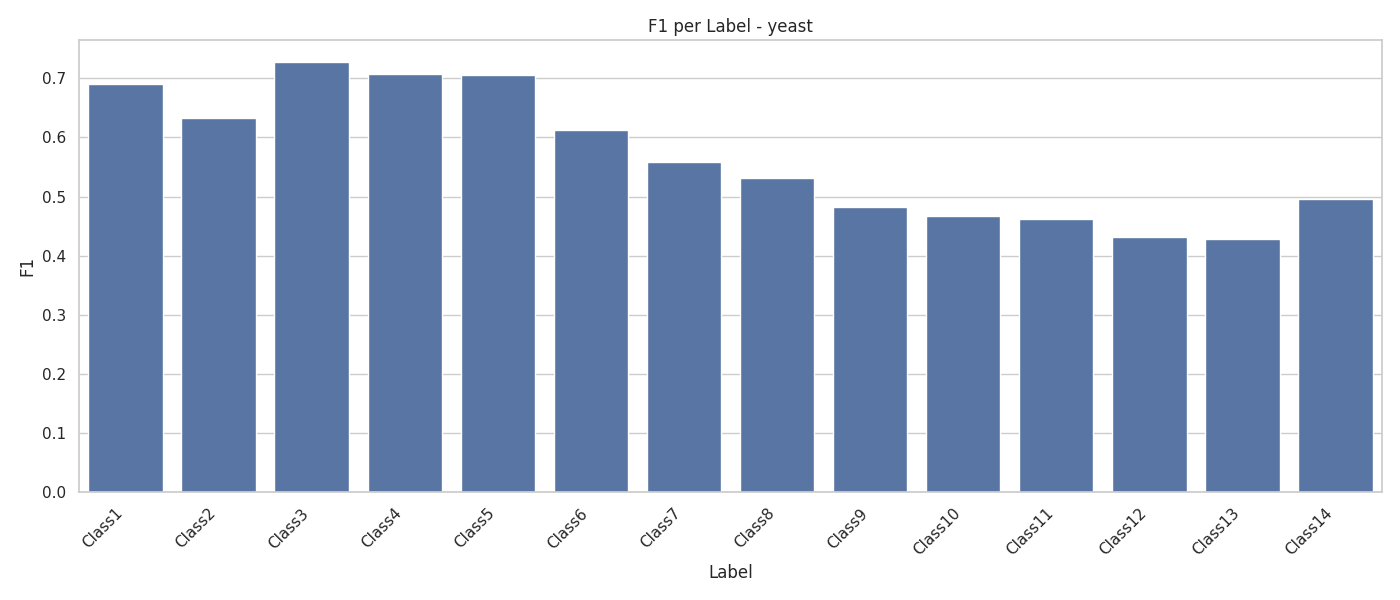

📊 yeast_precision_per_label.png


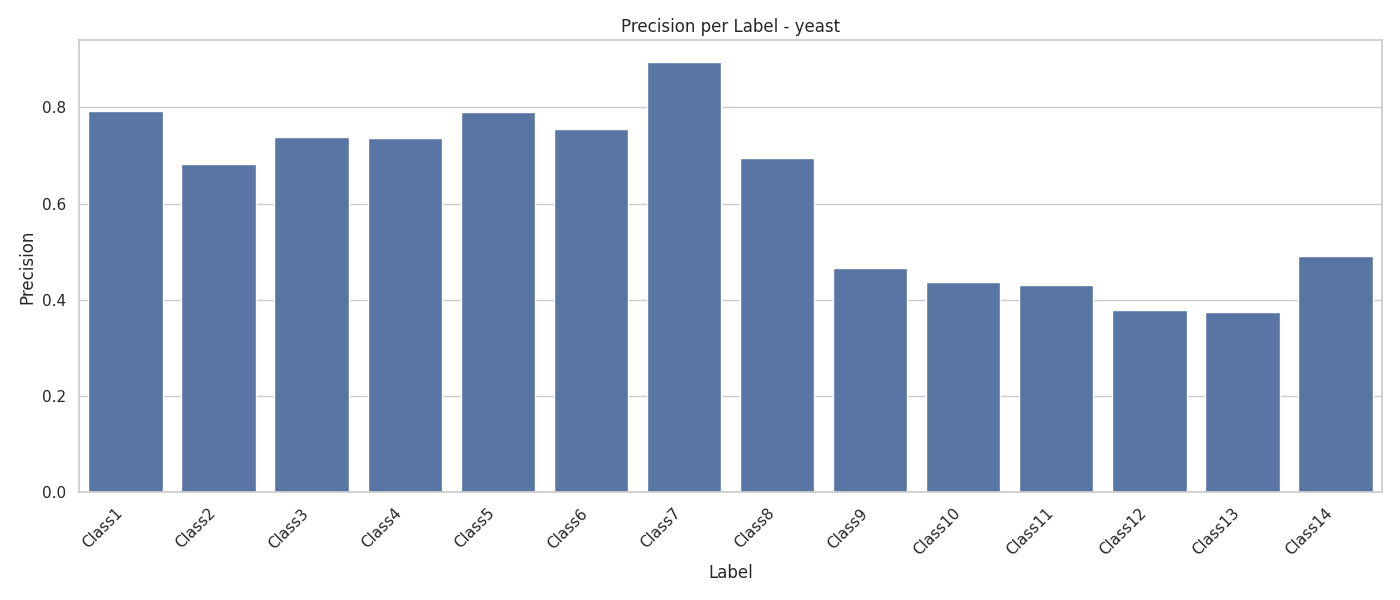

In [8]:
import matplotlib.pyplot as plt
import os
from IPython.display import Image, display

# List all image files in the plots directory
image_files = sorted([f for f in os.listdir("plots_multi_label") if f.endswith(".png")])

# Display each image
for img_file in image_files:
    print(f"📊 {img_file}")
    display(Image(filename=os.path.join("plots", img_file)))


In [9]:
# from IPython.display import Image, display

# # Show overall metrics
# display(Image("/content/plots/overall_micro_metrics.png"))

# # Show per-label metrics
# for metric in ["Accuracy", "Precision", "Recall", "F1"]:
#     display(Image(f"plots/{metric}_per_label.png"))

In [19]:
code = """
# ==============================
# 🚀 AutoSklearn for Multi-Output Regression with Preprocessing
# ==============================

if __name__ == "__main__":
    import matplotlib
    matplotlib.use('Agg')  # No GUI backend
    import matplotlib.pyplot as plt
    import openml
    import autosklearn.regression
    from sklearn.model_selection import train_test_split
    from sklearn.multioutput import MultiOutputRegressor
    from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
    import pandas as pd
    import numpy as np
    import time
    from sklearn.compose import ColumnTransformer
    from sklearn.preprocessing import OneHotEncoder
    from sklearn.impute import SimpleImputer
    import seaborn as sns
    import os

    dataset_ids = [41477, 41491, 41478]
    # dataset_ids = [41477]
    results = []
    metrics_data = {
        "Dataset": [],
        "R2 (Micro)": [],
        "MSE (Micro)": [],
        "MAE (Micro)": [],
        "Fit Time (s)": []
    }

    for openml_id in dataset_ids:
        print("\U0001F680 Running Auto-Sklearn on Dataset " + str(openml_id))
        dataset = openml.datasets.get_dataset(openml_id)
        df, _, _, _ = dataset.get_data()

        target_cols = [col.strip() for col in dataset.default_target_attribute.split(",")]
        X = df.drop(columns=target_cols)
        y = df[target_cols].astype(np.float64)

        categorical_cols = X.select_dtypes(include=["object", "category"]).columns
        numeric_cols = X.select_dtypes(include=["number", "bool"]).columns

        preprocessor = ColumnTransformer([
            ("num", SimpleImputer(strategy="mean"), numeric_cols),
            ("cat", OneHotEncoder(handle_unknown="ignore", sparse=False), categorical_cols),
        ])

        X_processed = preprocessor.fit_transform(X)
        X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.33, random_state=42)

        base_regressor = autosklearn.regression.AutoSklearnRegressor(
            time_left_for_this_task=60,
            per_run_time_limit=30,
            n_jobs=-1,
            initial_configurations_via_metalearning=25,
        )
        model = MultiOutputRegressor(base_regressor)

        start_time = time.time()
        model.fit(X_train, y_train)
        fit_time = time.time() - start_time

        y_pred = model.predict(X_test)

        target_metrics = {}
        r2_scores, mses, maes = [], [], []

        for i, col in enumerate(y.columns):
            y_true = y_test.iloc[:, i]
            y_pred_col = y_pred[:, i]
            mse = mean_squared_error(y_true, y_pred_col)
            r2 = r2_score(y_true, y_pred_col)
            mae = mean_absolute_error(y_true, y_pred_col)

            target_metrics[f"{col}_R2"] = round(r2, 4)
            target_metrics[f"{col}_MSE"] = round(mse, 4)
            target_metrics[f"{col}_MAE"] = round(mae, 4)

            r2_scores.append(r2)
            mses.append(mse)
            maes.append(mae)

        avg_r2 = np.mean(r2_scores)
        avg_mse = np.mean(mses)
        avg_mae = np.mean(maes)

        metrics_data["Dataset"].append(dataset.name)
        metrics_data["R2 (Micro)"].append(round(avg_r2, 4))
        metrics_data["MSE (Micro)"].append(round(avg_mse, 4))
        metrics_data["MAE (Micro)"].append(round(avg_mae, 4))
        metrics_data["Fit Time (s)"].append(round(fit_time, 2))

        result_row = {
            "Dataset ID": openml_id,
            "Dataset Name": dataset.name,
            "R2 (Micro)": round(avg_r2, 4),
            "MSE (Micro)": round(avg_mse, 4),
            "MAE (Micro)": round(avg_mae, 4),
            "Fit Time (s)": round(fit_time, 2),
        }
        result_row.update(target_metrics)
        results.append(result_row)

    # ==============================
    # 📁 Save Summary & Plots
    # ==============================
    results_df = pd.DataFrame(results)
    results_df.to_csv("autosklearn_multioutput_results.csv", index=False)

    metrics_df = pd.DataFrame(metrics_data)
    metrics_df.to_csv("autosklearn_micro_metrics.csv", index=False)

    os.makedirs("plots", exist_ok=True)
    sns.set_theme(style="whitegrid")

    # 1. Micro Metrics Overview
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    bars = [
        ("R2 (Micro)", axes[0, 0], 'R2 Score (Micro)'),
        ("MSE (Micro)", axes[0, 1], 'Mean Squared Error (Micro)'),
        ("MAE (Micro)", axes[1, 0], 'Mean Absolute Error (Micro)'),
        ("Fit Time (s)", axes[1, 1], 'Training Time (s)')
    ]
    for metric, ax, title in bars:
        sns.barplot(data=metrics_df, x="Dataset", y=metric, ax=ax)
        for container in ax.containers:
            ax.bar_label(container, fmt="%.3f", label_type="edge", fontsize=9)
        ax.set_title(title)
        ax.tick_params(axis='x', rotation=45)
    plt.tight_layout()
    plt.savefig("plots/overall_multioutput_metrics.png")
    plt.close()

    # 2. Line Plots per Target across Datasets
    for metric in ["R2", "MSE", "MAE"]:
        plt.figure(figsize=(16, 6))
        label_set = set()
        for result in results:
            label_set.update([key.replace(f"_{metric}", "") for key in result if key.endswith(f"_{metric}")])
        for label in sorted(label_set):
            y_vals = [res.get(f"{label}_{metric}", 0) for res in results]
            x_vals = [res["Dataset ID"] for res in results]
            plt.plot(x_vals, y_vals, label=label, marker='o')
        plt.title(f'{metric} per Target across Datasets')
        plt.xlabel('Dataset ID')
        plt.ylabel(metric)
        plt.legend(title="Target", bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.savefig(f"plots/{metric}_per_target_across_datasets.png")
        plt.close()

    # 3. Per-Dataset Bar Plots per Target
    for result in results:
        dataset_id = result["Dataset ID"]
        for metric in ["R2", "MSE", "MAE"]:
            labels, values = [], []
            for key in result:
                if key.endswith(f"_{metric}"):
                    labels.append(key.replace(f"_{metric}", ""))
                    values.append(result[key])
            if not labels:
                continue
            plt.figure(figsize=(14, 6))
            ax = sns.barplot(x=labels, y=values)
            plt.title(f"{metric} per Target - Dataset {dataset_id}")
            plt.xlabel("Target")
            plt.ylabel(metric)
            plt.xticks(rotation=45, ha="right")
            for container in ax.containers:
                ax.bar_label(container, fmt="%.3f", label_type="edge", fontsize=9)
            plt.tight_layout()
            plt.savefig(f"plots/dataset_{dataset_id}_{metric.lower()}_per_target.png")
            plt.close()

    print("\U0001F389 All plots and results saved!")




"""
# Save the code to a Python script file
with open("autosklearn_testing.py", "w") as f:
    f.write(code)

# Step 4: Run the script using the virtual environment
!py38env/bin/python autosklearn_testing.py

🚀 Running Auto-Sklearn on Dataset 41477
[WARNING] [2025-05-01 10:10:15,970:Client-AutoML(1):789a349a-2674-11f0-b665-0242ac1c000c] Capping the per_run_time_limit to 29.0 to have time for a least 2 models in each process.
[WARNING] [2025-05-01 10:11:19,411:Client-AutoML(1):9f7651e3-2674-11f0-b665-0242ac1c000c] Capping the per_run_time_limit to 29.0 to have time for a least 2 models in each process.
🚀 Running Auto-Sklearn on Dataset 41491
[WARNING] [2025-05-01 10:12:15,626:Client-AutoML(1):c0d42243-2674-11f0-b665-0242ac1c000c] Capping the per_run_time_limit to 29.0 to have time for a least 2 models in each process.
[WARNING] [2025-05-01 10:13:10,796:Client-AutoML(1):e24bc492-2674-11f0-b665-0242ac1c000c] Capping the per_run_time_limit to 29.0 to have time for a least 2 models in each process.
[WARNING] [2025-05-01 10:14:05,919:Client-AutoML(1):0302aae9-2675-11f0-b665-0242ac1c000c] Capping the per_run_time_limit to 29.0 to have time for a least 2 models in each process.
[WARNING] [2025-05-0

📊 MAE_per_target_across_datasets.png


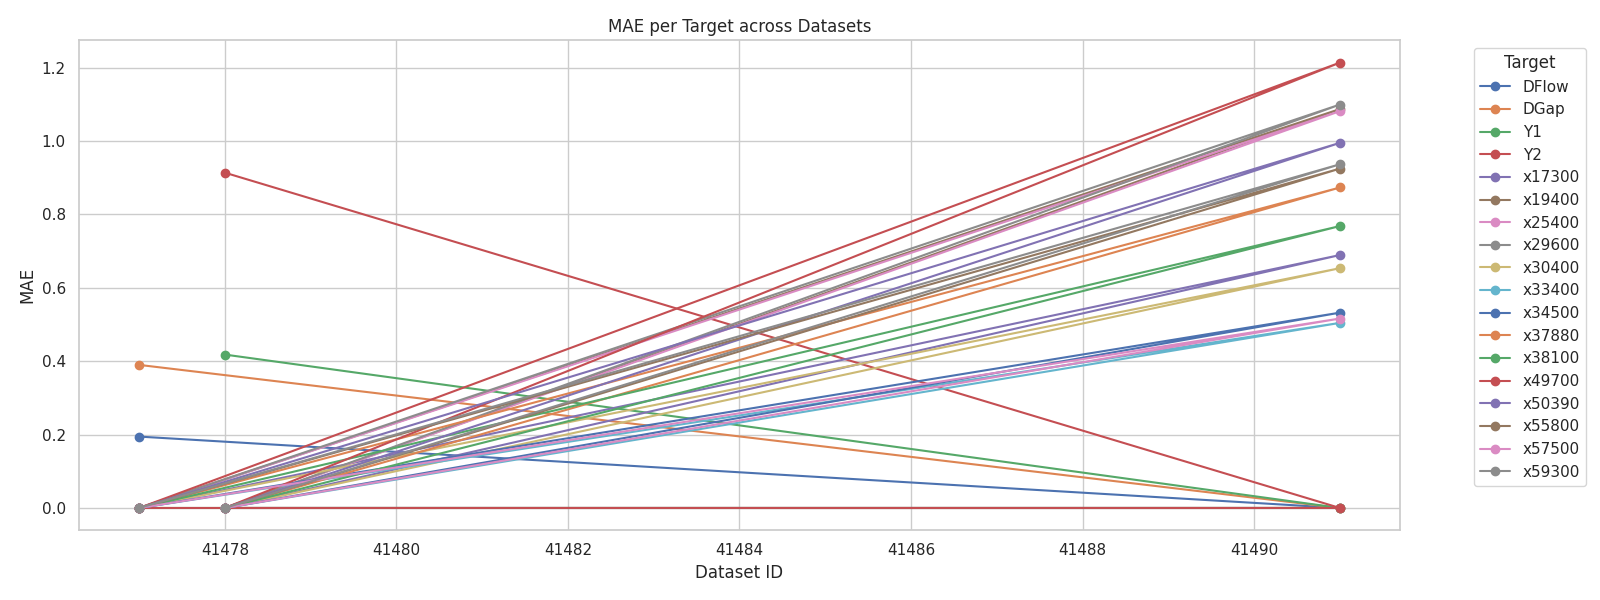

📊 MSE_per_target_across_datasets.png


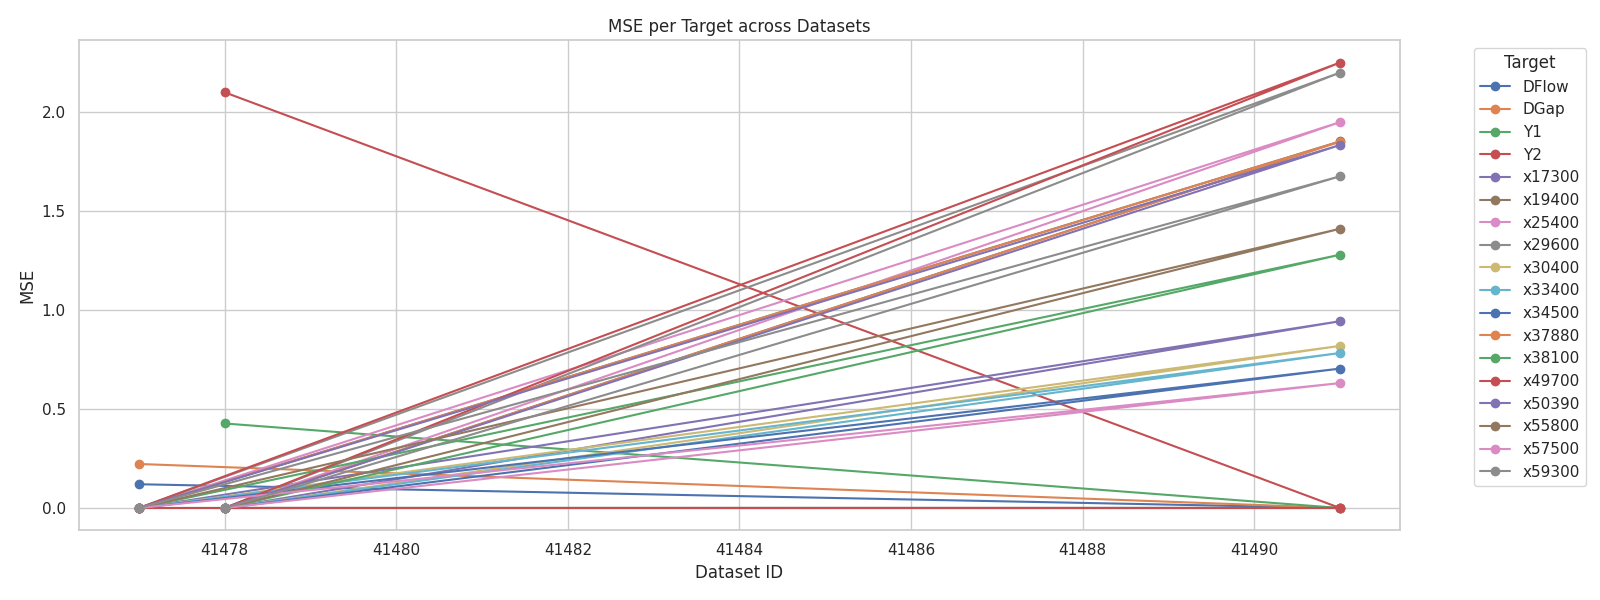

📊 R2_per_target_across_datasets.png


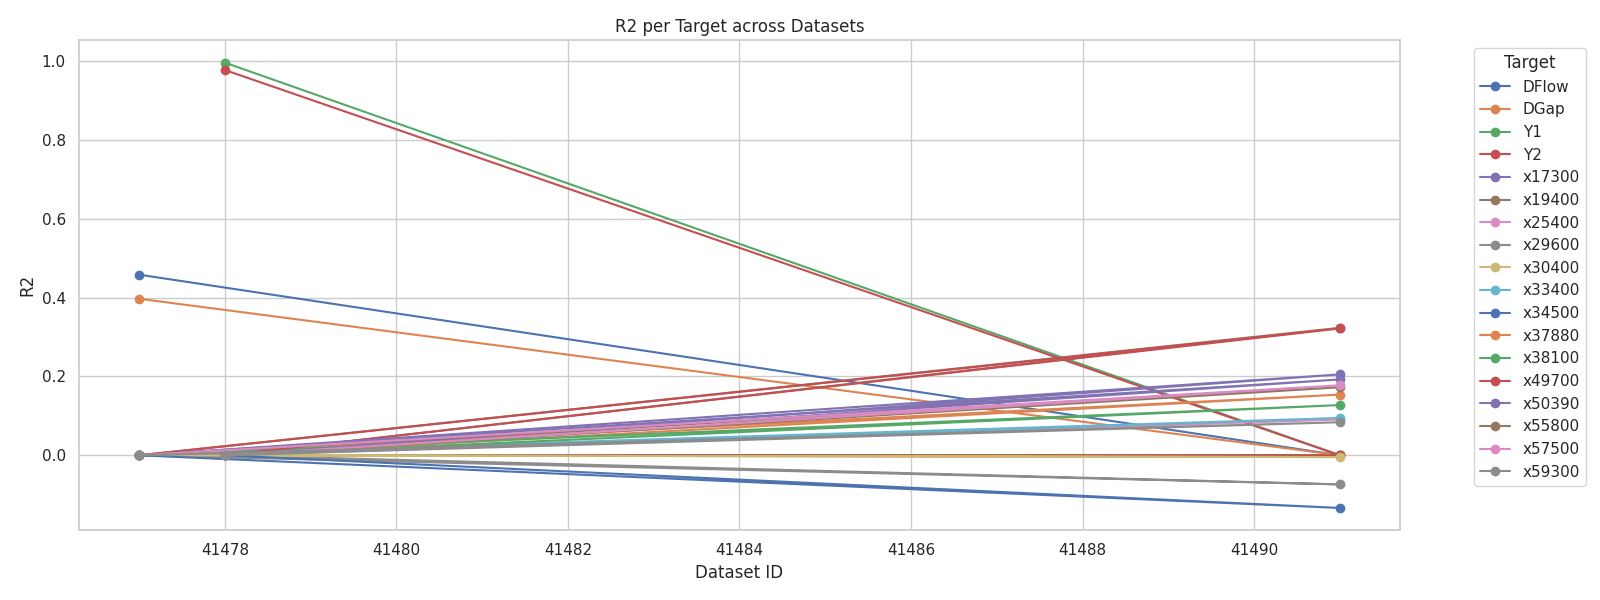

📊 dataset_41477_mae_per_target.png


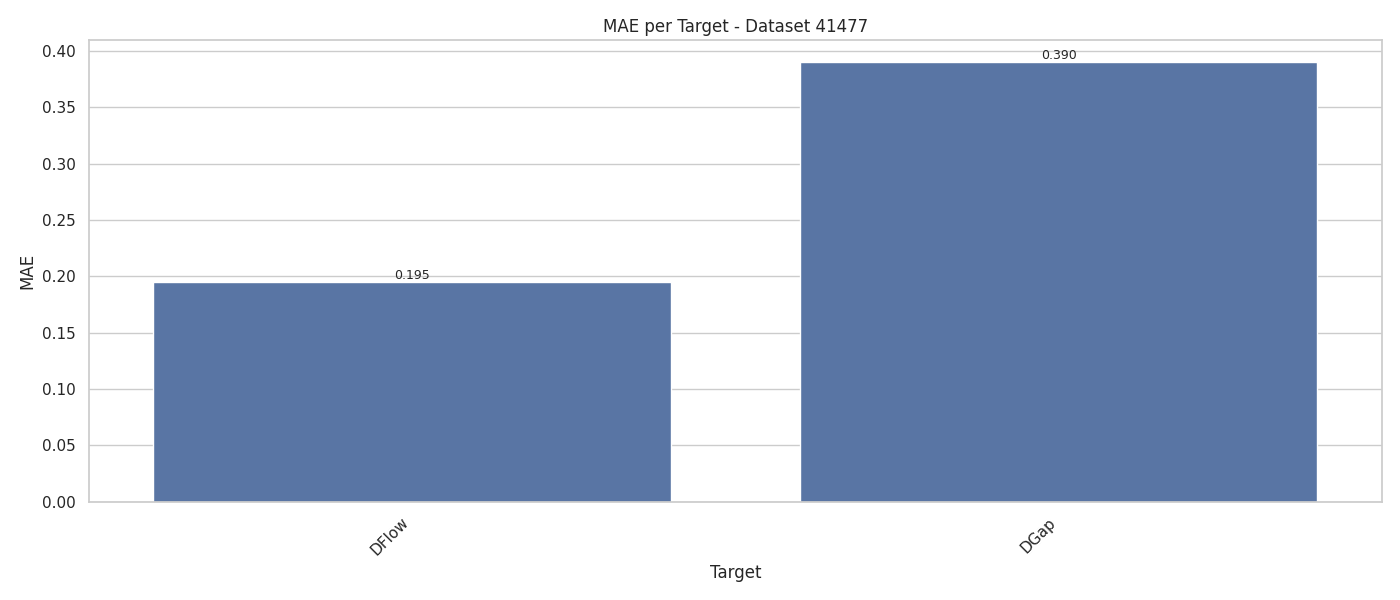

📊 dataset_41477_mse_per_target.png


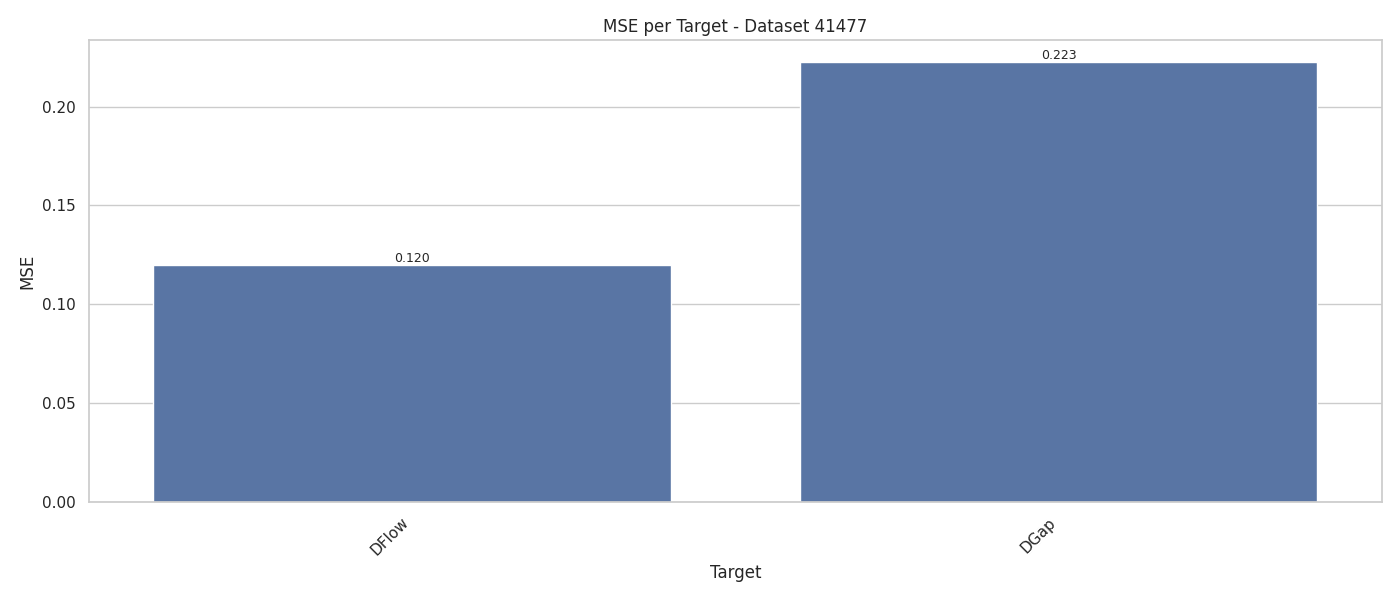

📊 dataset_41477_r2_per_target.png


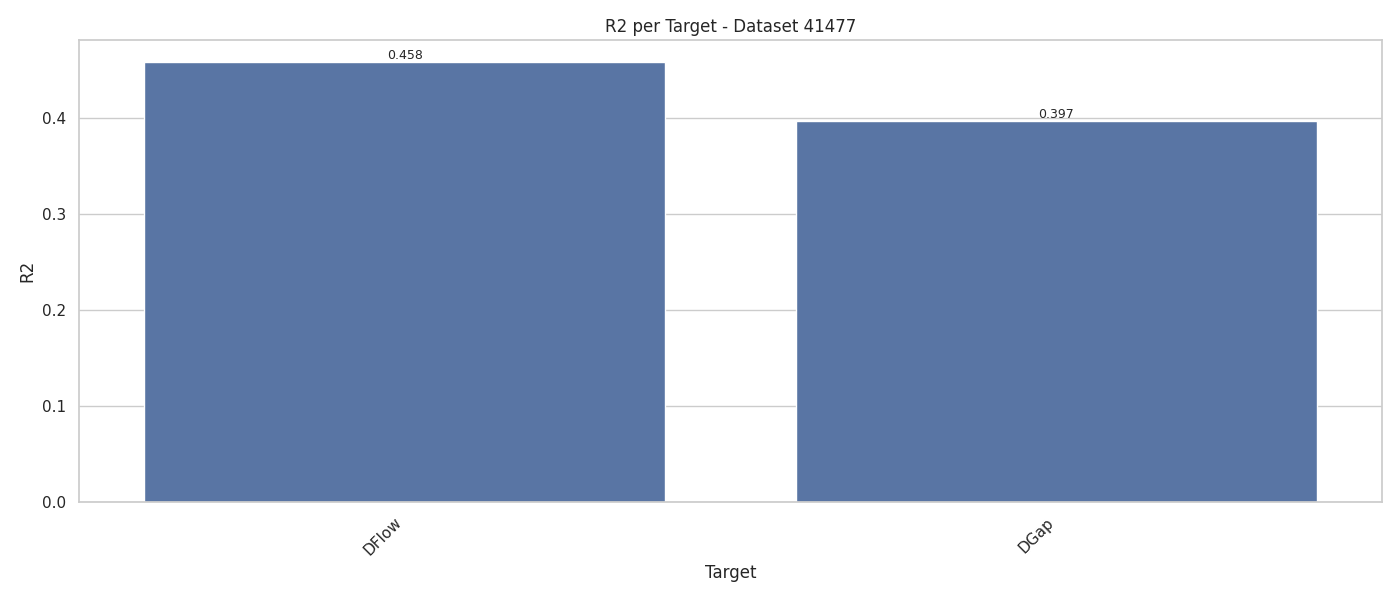

📊 dataset_41478_mae_per_target.png


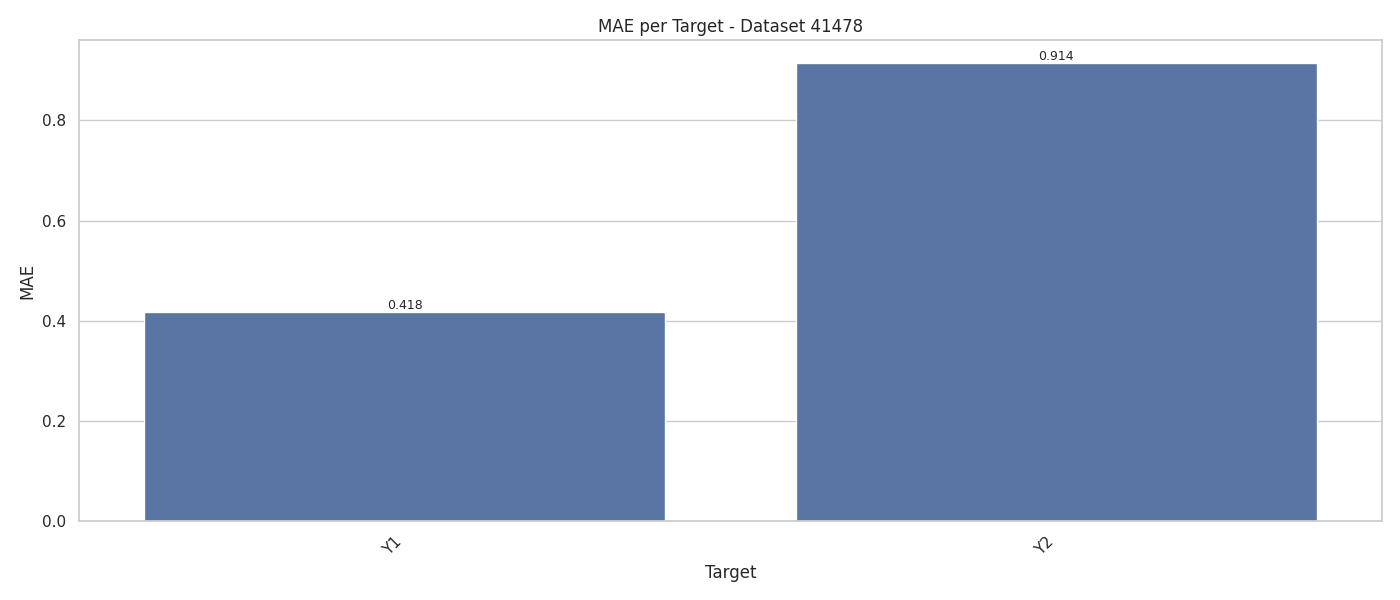

📊 dataset_41478_mse_per_target.png


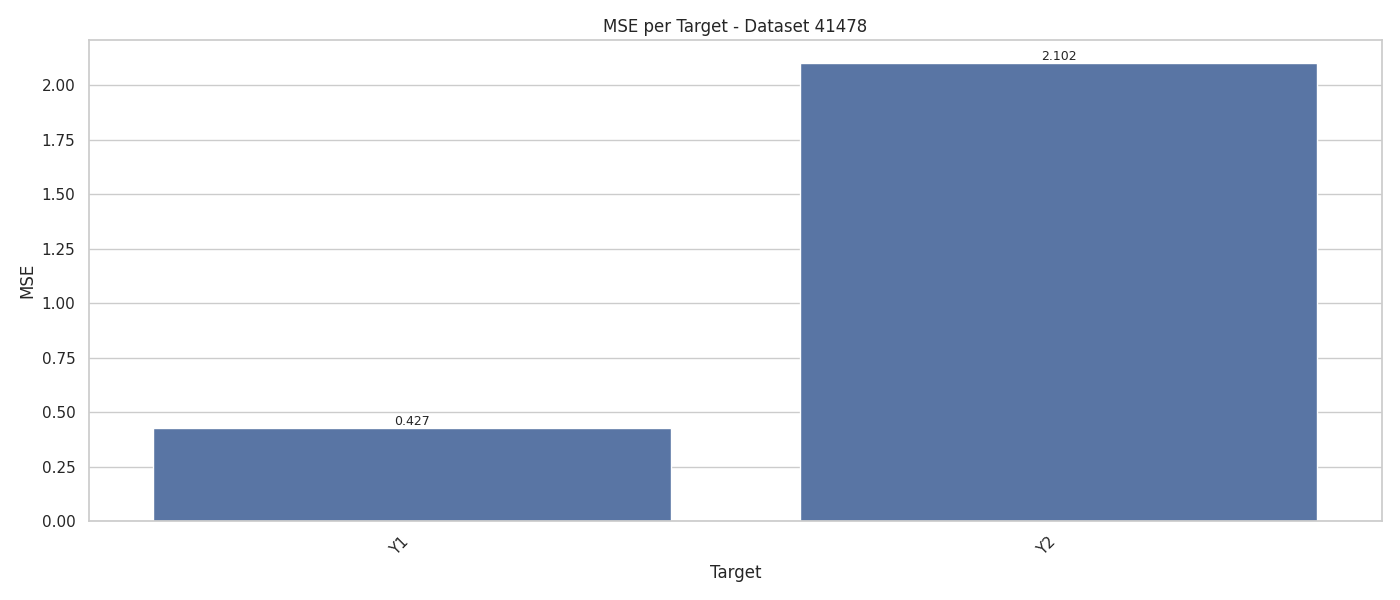

📊 dataset_41478_r2_per_target.png


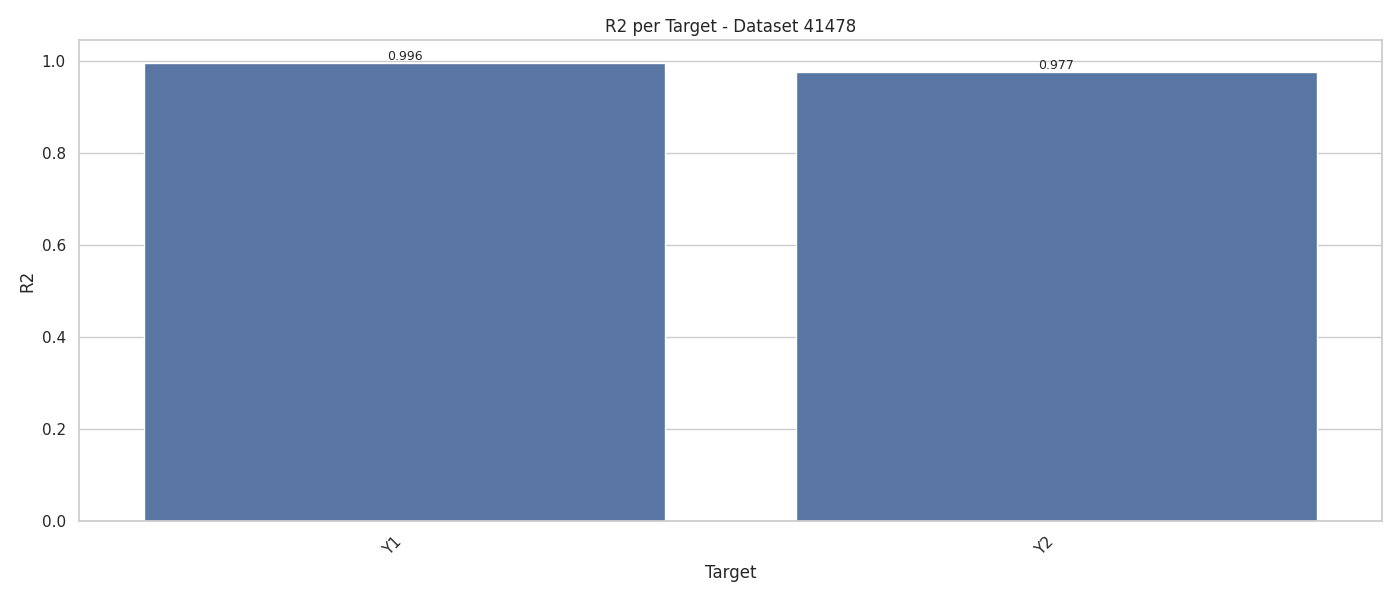

📊 dataset_41491_mae_per_target.png


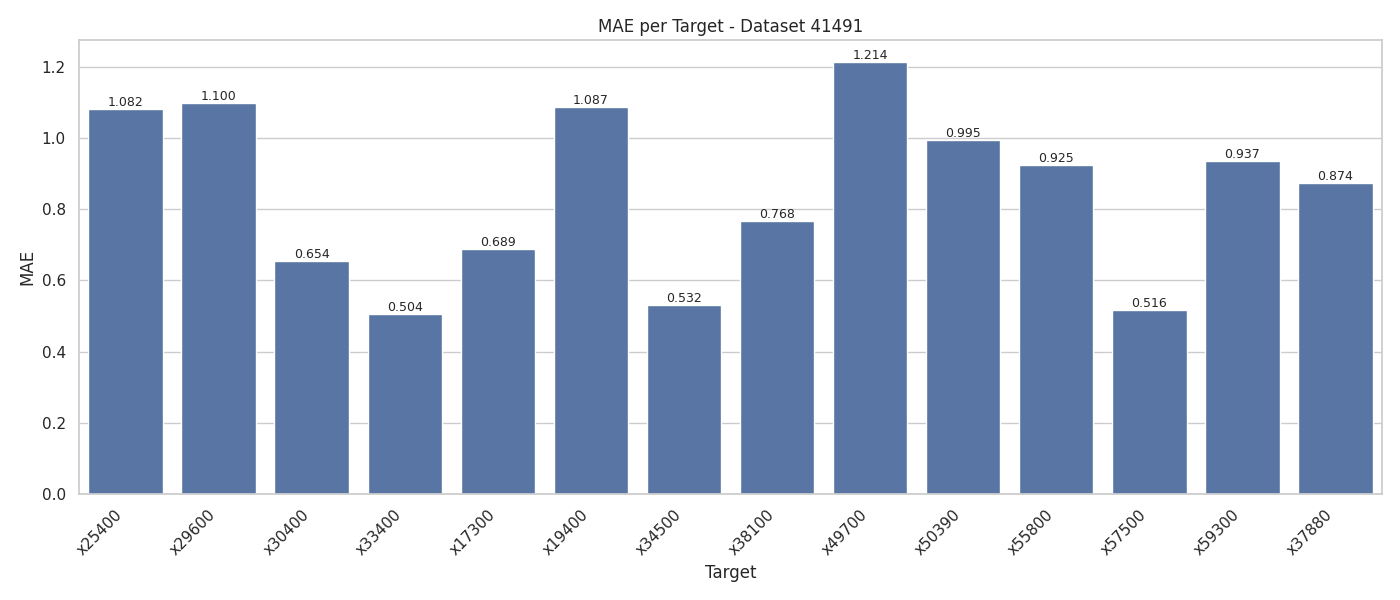

📊 dataset_41491_mse_per_target.png


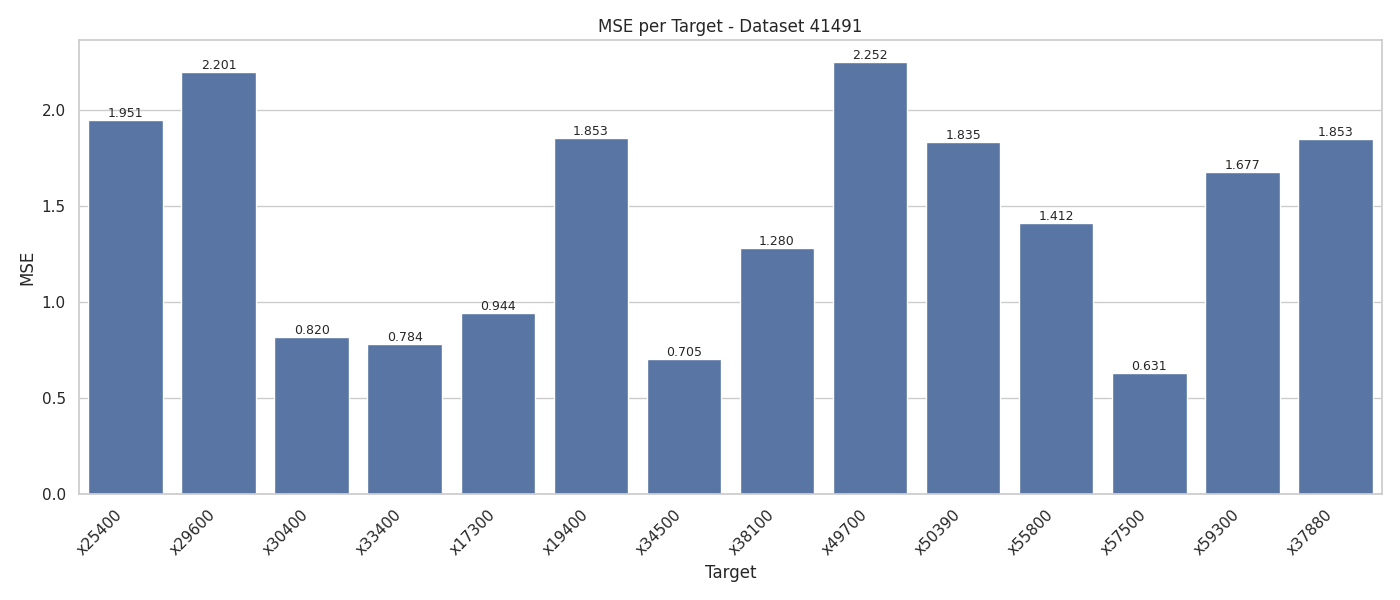

📊 dataset_41491_r2_per_target.png


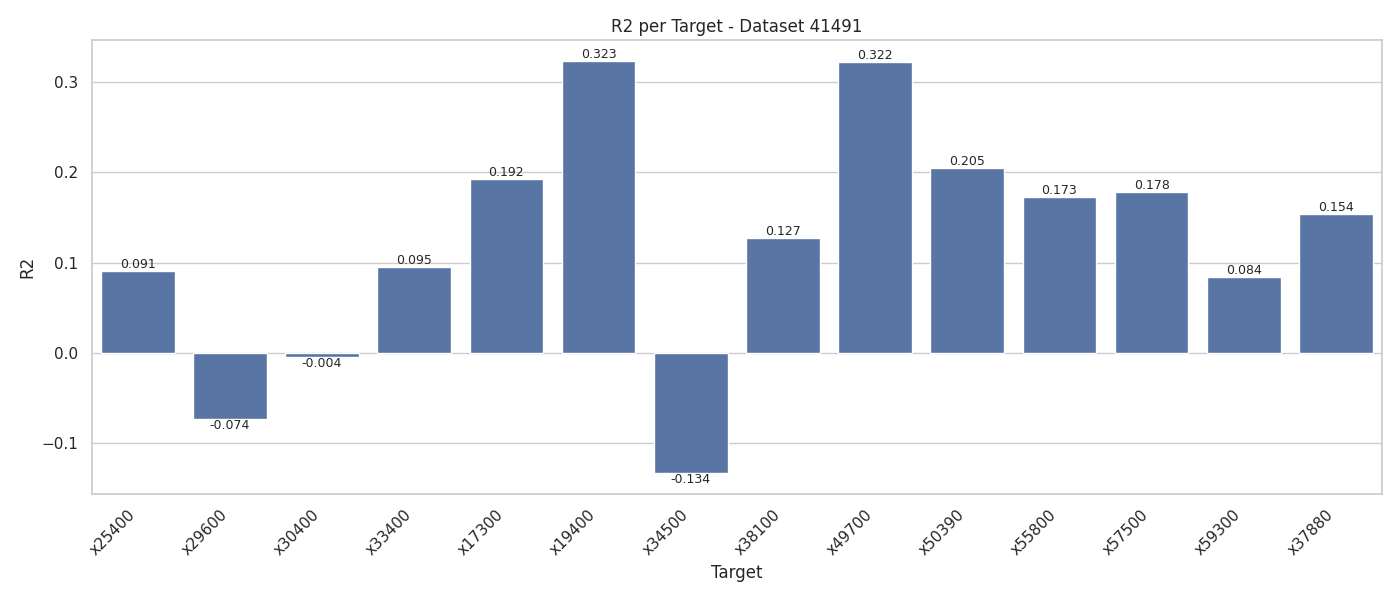

📊 overall_multioutput_metrics.png


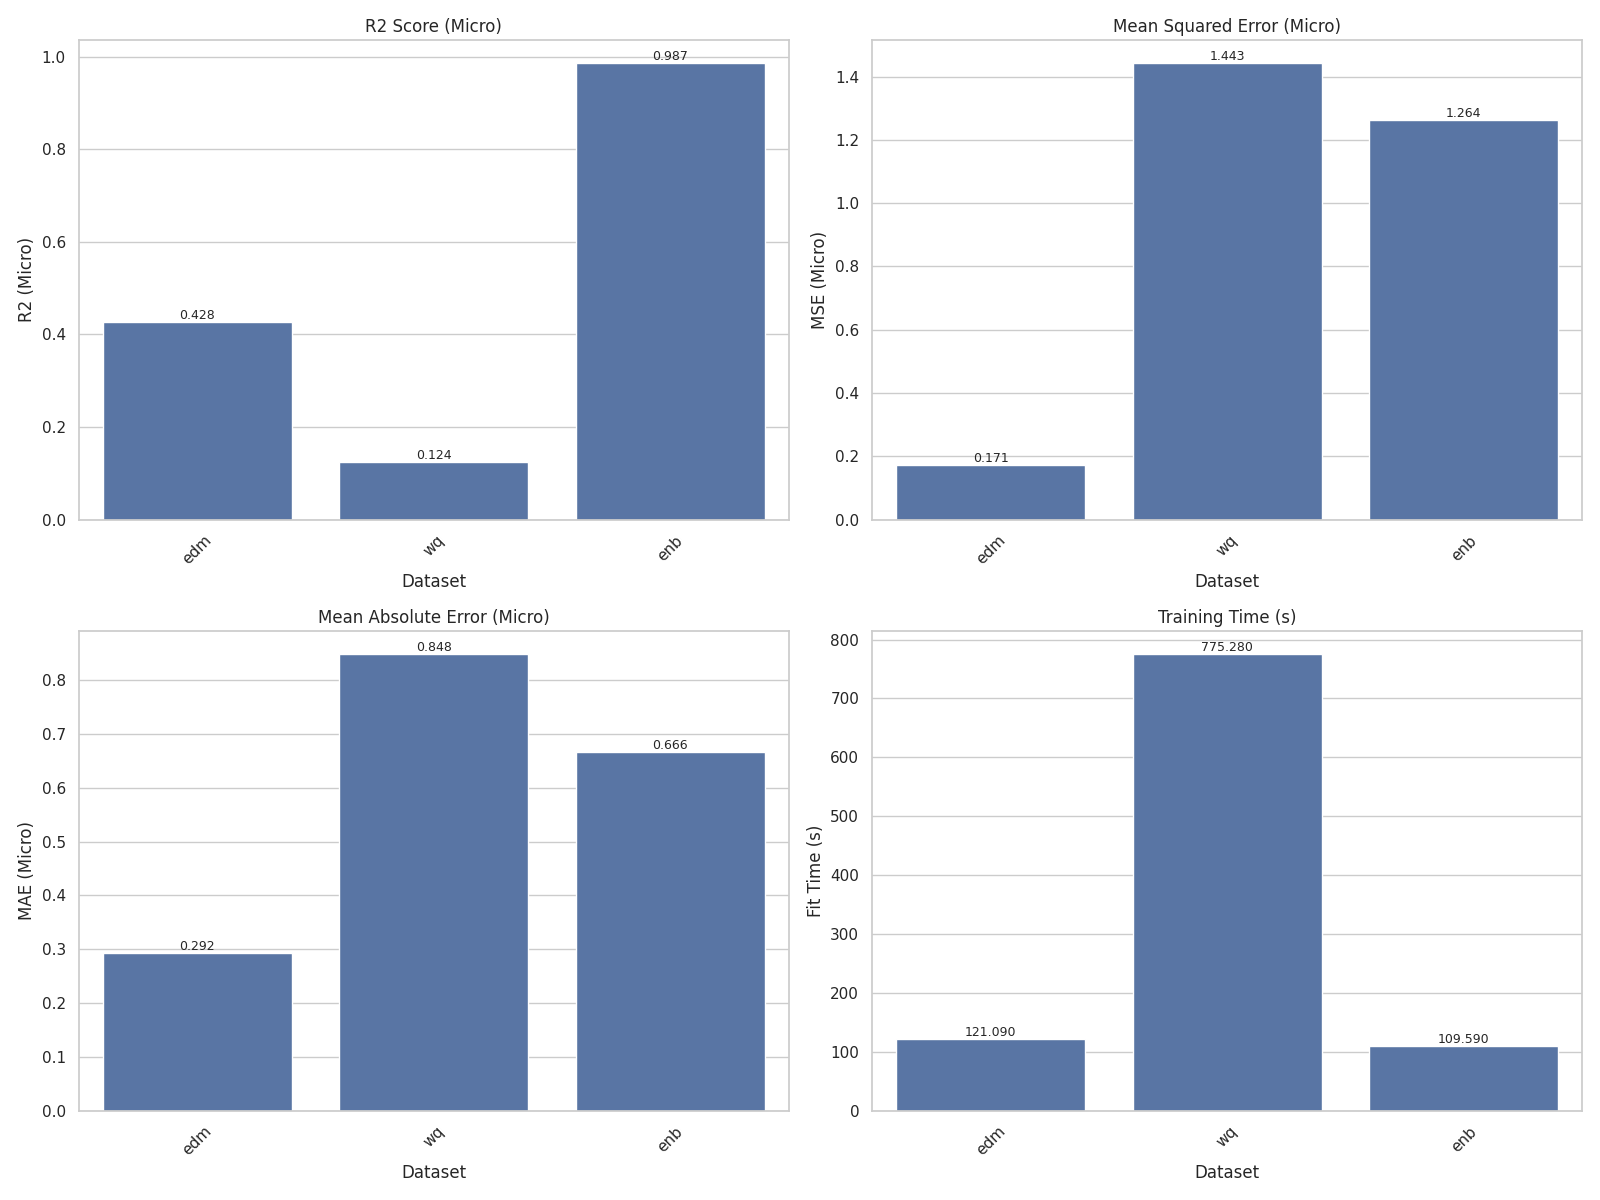

In [24]:
import matplotlib.pyplot as plt
import os
from IPython.display import Image, display

# List all image files in the plots directory
image_files = sorted([f for f in os.listdir("plots") if f.endswith(".png")])

# Display each image
for img_file in image_files:
    print(f"📊 {img_file}")
    display(Image(filename=os.path.join("plots", img_file)))


In [25]:
# prompt: download folder /content/plots_multi_label locally

from google.colab import files
import zipfile

# Create a zip file of the plots directory
!zip -r /content/plots.zip /content/plots

# Download the zip file
files.download("/content/plots.zip")


  adding: content/plots/ (stored 0%)
  adding: content/plots/dataset_41478_r2_per_target.png (deflated 30%)
  adding: content/plots/dataset_41477_mae_per_target.png (deflated 29%)
  adding: content/plots/dataset_41477_r2_per_target.png (deflated 28%)
  adding: content/plots/dataset_41491_r2_per_target.png (deflated 21%)
  adding: content/plots/dataset_41477_mse_per_target.png (deflated 29%)
  adding: content/plots/MAE_per_target_across_datasets.png (deflated 3%)
  adding: content/plots/dataset_41478_mse_per_target.png (deflated 28%)
  adding: content/plots/dataset_41478_mae_per_target.png (deflated 29%)
  adding: content/plots/overall_multioutput_metrics.png (deflated 25%)
  adding: content/plots/MSE_per_target_across_datasets.png (deflated 4%)
  adding: content/plots/dataset_41491_mae_per_target.png (deflated 21%)
  adding: content/plots/dataset_41491_mse_per_target.png (deflated 21%)
  adding: content/plots/R2_per_target_across_datasets.png (deflated 7%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


🖼️ Displaying Overall Metrics Plot


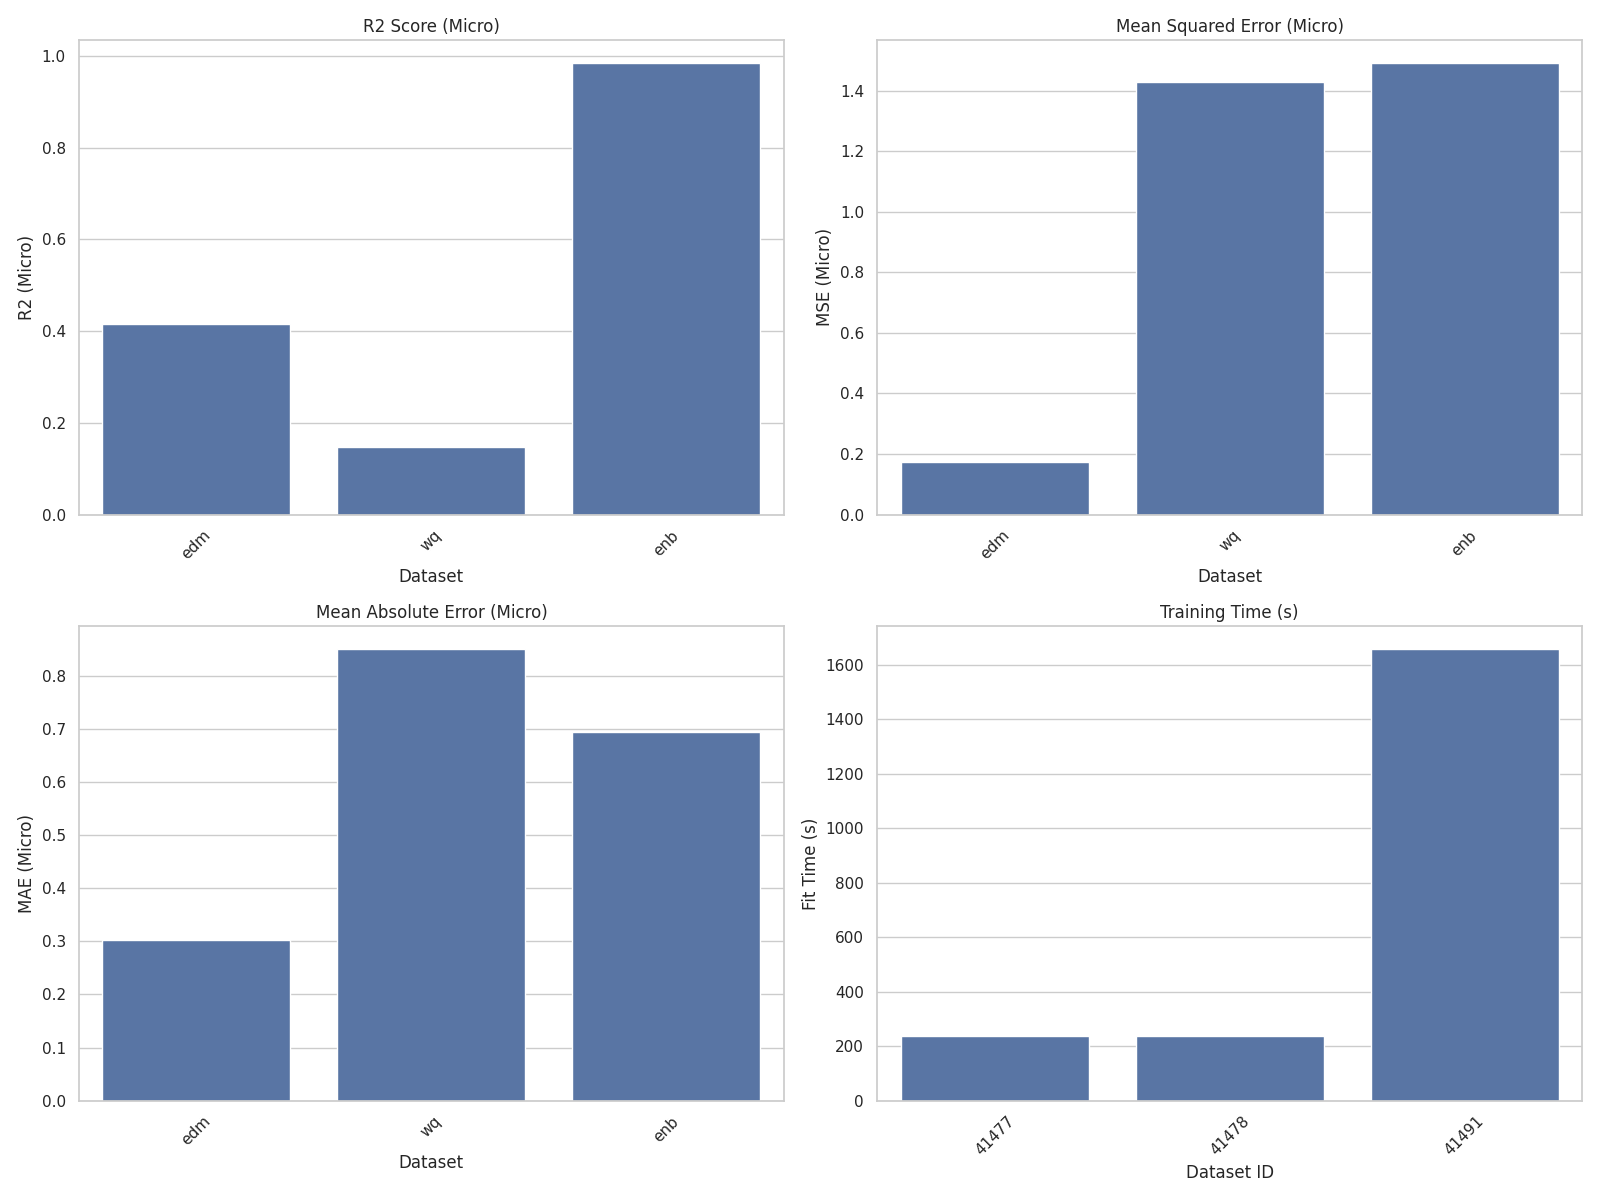


🖼️ Displaying Per-Target Metrics Plots

📈 R2 per Target


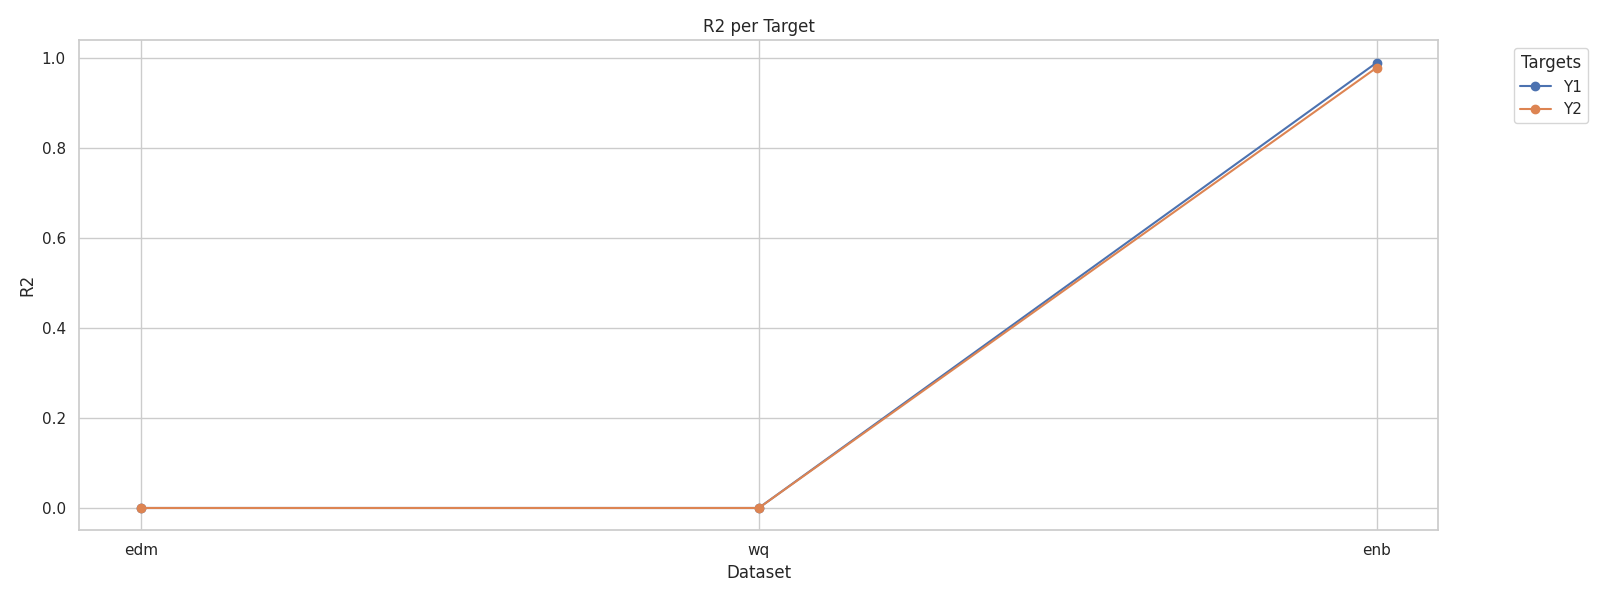


📈 MSE per Target


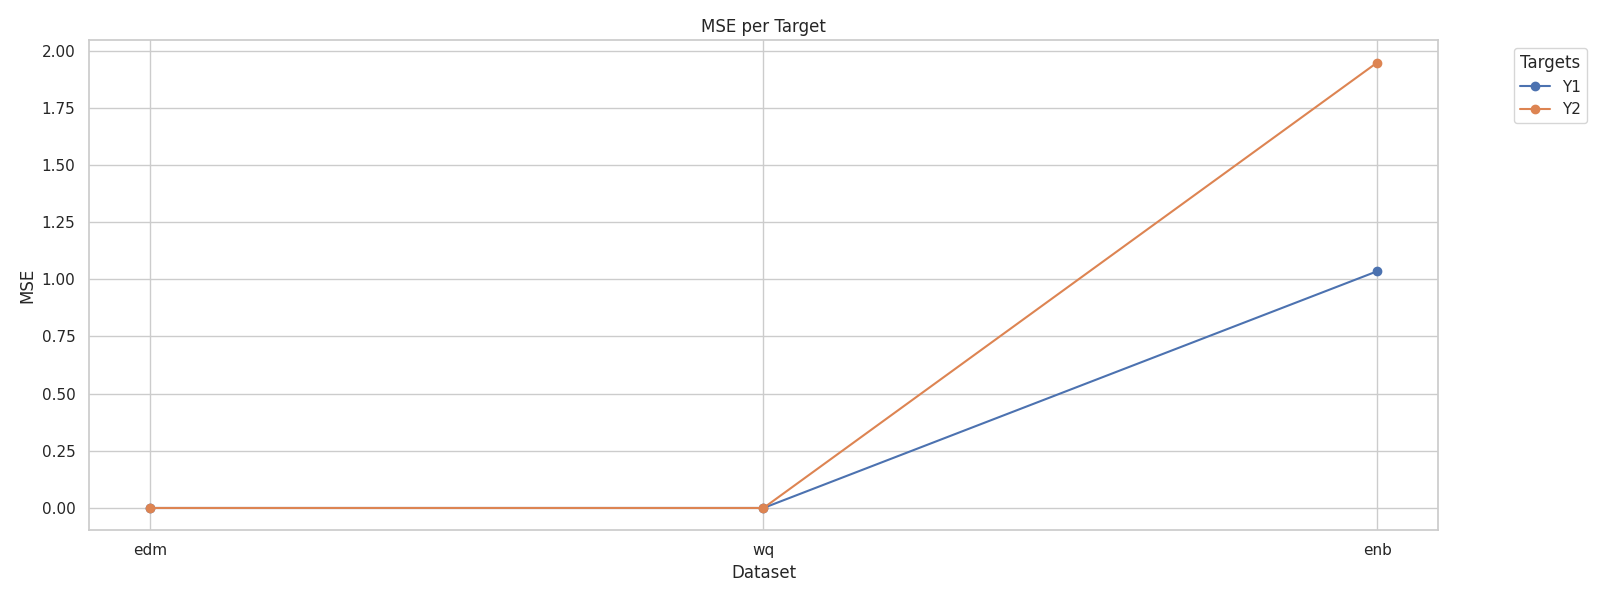


📈 MAE per Target


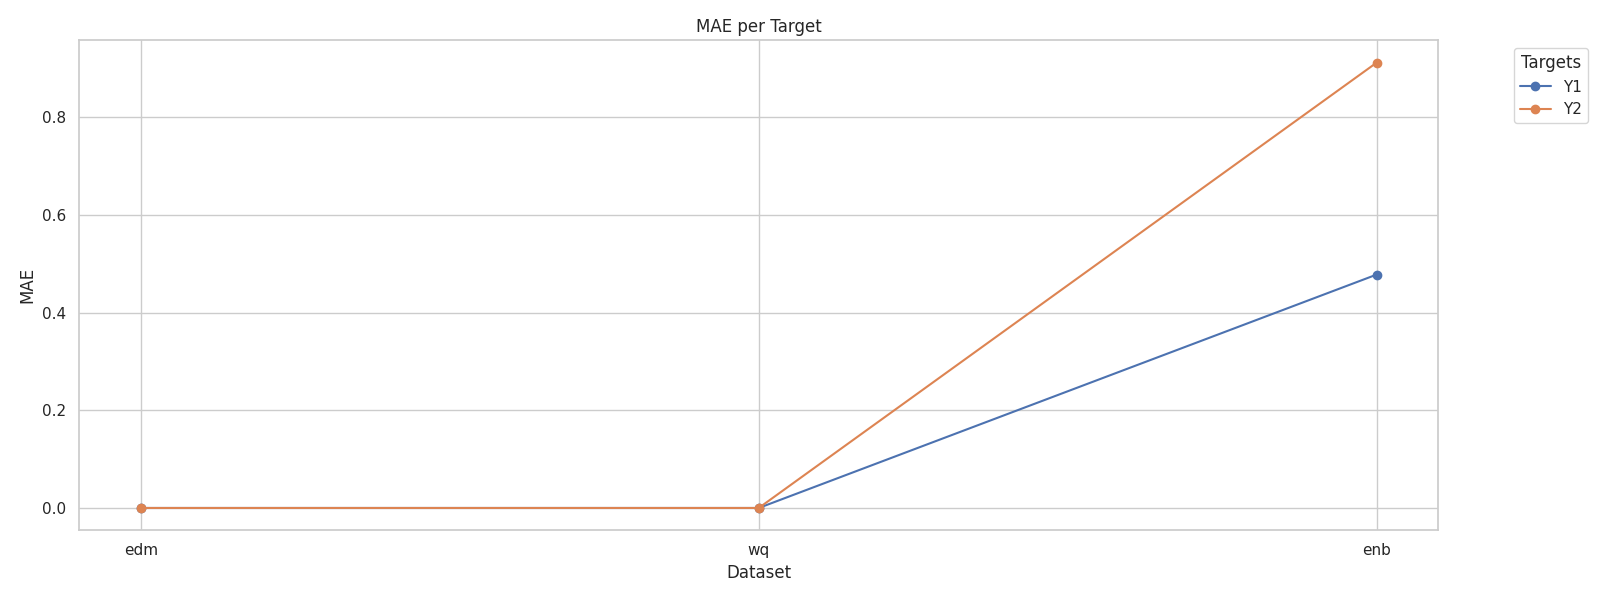

In [ ]:
# from IPython.display import Image, display

# print("\n🖼️ Displaying Overall Metrics Plot")
# display(Image("plots/overall_multioutput_metrics.png"))

# print("\n🖼️ Displaying Per-Target Metrics Plots")
# for metric in ["R2", "MSE", "MAE"]:
#     print(f"\n📈 {metric} per Target")
#     display(Image(f"plots/{metric}_per_target.png"))

In [ ]:
# !py38env/bin/python /kaggle/input/optria/vi.py


In [ ]:
# # Save this mini script
# with open("plot_test_script.py", "w") as f:
#     f.write("""
# import matplotlib.pyplot as plt

# # Simple plot
# x = [1, 2, 3, 4]
# y = [10, 20, 25, 30]

# plt.plot(x, y)
# plt.title("Test Plot")

# # Save plot instead of showing
# plt.savefig("test_plot.png")
# plt.close()

# print("✅ Plot saved as test_plot.png")
# """)

# !python plot_test_script.py
# from IPython.display import Image, display

# display(Image("test_plot.png"))
